## 04_Clean_RawBuoyData

* Grab buoy data from Bliss & Hutchings
* Remove erroneous lat/lon coordinates
* Save data to csvs to use for position interpolation later in analysis. 


## Import packages

In [1]:
# # math
# import numpy as np
# import numpy.ma as ma
# from bisect import bisect_left

# # navigating local files
# import sys, os, glob
# user = os.getlogin()

# # data
# import pandas as pd
# import xarray as xr

# # geo
# from pyproj import Geod
# from shapely import wkt
# from shapely.geometry import Point
# import pyproj
# geodesic_path = pyproj.Geod(ellps='WGS84')

# # time
# import datetime

# # plotting
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.colors
# import matplotlib.gridspec as gridspec
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeat
# from cartopy.mpl.geoaxes import GeoAxes


# # metpy
# import metpy.calc
# from metpy.units import units

# # Import the geodesic module from geopy library 
# from geopy.distance import geodesic
# from pyproj import Geod
# g = Geod(ellps='WGS84')

# from metpy.units import units




# # ignore shapely warning for geographic plots
# import shapely
# import warnings
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


# # import my own functions from within the same repository 
# #********************************************************
# # sys.path.append('./scripts/')
# # from LIB_accessIABP import (read_IABPdata_from_buoyID, read_IABPdata_from_localfile)
# # from LIB_geo_plot import (add_grid, add_coast, add_land, fix_cartopy_vectors)



# sys.path.append('/Users/mackenziejewell/Documents/GitHub/Libraries_functions/')
# from LIB_geo_func import (make_polygon,make_linestring, make_smooth_geographic_box, 
#                           regrid_geo_data, within_polygon_indices, polygon_mean_from_indices)
# from LIB_WillmesLeads import grab_WillmesLeads
# from LIB_PPdrift_NSIDC0116 import grab_ice_Drift, grab_icedrift_range
# from LIB_TB_NSIDC0001 import grab_TB_NSIDC0001
# from LIB_plotting import add_colorbar
# from LIB_sicNASAteam_NSIDC0051 import grab_sicNASAteam

# from LIB_geo_plot import (add_grid, add_coast, add_land, fix_cartopy_vectors, add_date)


# sys.path.append('./scripts/')
# from get_camp_track import GetCampPosition_cln

# from LIB_SIC_MODISAMSR2 import grab_SIC_MODISAMSR
# from analyze_SIDExbuoy import open_buoy_data, calc_velocity

%load_ext autoreload
%autoreload 2

from common_imports import *


import bisect
from pyproj import Geod
g = Geod(ellps='WGS84')


from pandas import Timestamp



def calculate_velocity(lons = [], lats = [], times = [], method = 'centered', skip_nans = True, acceleration = False):

#     method = 'centered'
#     method = 'forward'
#     method = 'backward'
    
    # whether or not to remove nan coordinates from velocity calculations
    # if False, would return nan velocities where nan coordinates exist
    
    if skip_nans:
        times = times[np.isnan(lons)==False]
        lons = lons[np.isnan(lats)==False]
        lats = lats[np.isnan(lats)==False]
        
    # times halfway between considered time steps
    time = np.array([])
    lon = np.array([])
    lat = np.array([])

    di = np.array([])
    az = np.array([])
    u = np.array([])
    v = np.array([])
    dx = np.array([])
    dy = np.array([])
    sp = np.array([])
    dt = np.array([])

    if str(method) == 'forward':
        index_range = range(0, len(lons)-1)
    elif str(method) == 'centered':
        index_range = range(1, len(lons)-1)
    elif str(method) == 'backward':
        index_range = range(1, len(lons))
            
            
    for ii in index_range:

        if str(method) == 'forward':
            ind_i = ii
            ind_f = ii+1
        elif str(method) == 'centered':
            ind_i = ii-1
            ind_f = ii+1
        elif str(method) == 'backward':
            ind_i = ii-1
            ind_f = ii
        else:
            break
            
        loc_i = (lats[ind_i], lons[ind_i])  # start location
        loc_f = (lats[ind_f], lons[ind_f])  # end location
        
        ti = times[ind_i]  # start time
        tf = times[ind_f]  # end time
        
        # compute forward and back azimuths, plus distance
        az12,az21,dist = g.inv(loc_i[1],loc_i[0],loc_f[1],loc_f[0])
        DI = dist*units('meter').to('cm')

        # angle from east
        beta = 90 * units('degree') - az12 * units('degree')
        if beta <= -180*units('degree'):
            beta += 360*units('degree')

        # calculate zonal, meridional displacements fmor azimuth
        DX = (dist*units('meter') * np.cos(beta.to('radian'))).to('cm')
        DY = (dist*units('meter') * np.sin(beta.to('radian'))).to('cm')
        
        # calculate length of timesteps used to calculate velocity
        DT = (tf - ti).total_seconds() * units('second')
        
        # save corresponding time to array
        if str(method) == 'forward':
            time = np.append(time, ti)
            lon = np.append(lon, loc_i[1])
            lat = np.append(lat, loc_i[0])
        elif str(method) == 'centered':
            time = np.append(time, times[ii])
            lon = np.append(lon, lons[ii])
            lat = np.append(lat, lats[ii])
        elif str(method) == 'backward':
            time = np.append(time, tf)
            lon = np.append(lon, loc_f[1])
            lat = np.append(lat, loc_f[0])
            
            
        u = np.append(u, DX/DT)
        v = np.append(v, DY/DT)
        sp = np.append(sp, DI/DT)
        dx = np.append(dx, DX)
        dy = np.append(dy, DY)
        di = np.append(di, DI)
        az  = np.append(az, az12)
        dt = np.append(dt, DT)

    
    if not acceleration:
        return u, v, sp, time, lat, lon, dx, dy, di, az, dt
    
    else:
        
        if str(method) == 'forward':
            
            index_range = range(0, len(time)-1)
            
            # calculate forward-looking accelerations 
            # (time step tt's acceleration assigned as between (tt) and (tt+1))
            DT = np.array([(time[tt+1]-time[tt]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt+1]-u[tt]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt+1]-v[tt]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(DU/DT, np.nan)
            av = np.append(DV/DT, np.nan)
            acc = np.append(np.sqrt(DU**2+DV**2)/DT, np.nan)
            
        elif str(method) == 'centered':
            
            index_range = range(1, len(time)-1)
            
            # calculate centered accelerations 
            # (time step tt's acceleration assigned as between (tt-1) and (tt+1))
            DT = np.array([(time[tt+1]-time[tt-1]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt+1]-u[tt-1]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt+1]-v[tt-1]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(np.append(np.nan, DU/DT), np.nan)
            av = np.append(np.append(np.nan, DV/DT), np.nan)
            acc = np.append(np.append(np.nan, np.sqrt(DU**2+DV**2)/DT), np.nan)
            
        elif str(method) == 'backward':
            
            index_range = range(1, len(time))
            
            # calculate backward-looking accelerations 
            # (time step tt's acceleration assigned as between (tt-1) and (tt))
            DT = np.array([(time[tt]-time[tt-1]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt]-u[tt-1]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt]-v[tt-1]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(np.nan, DU/DT)
            av = np.append(np.nan, DV/DT)
            acc = np.append(np.nan, np.sqrt(DU**2+DV**2)/DT)
            
        
        return u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, acc
    
    

In [2]:

# function to return height/width ratio 
# that should be used to create realistic map dimensions

def h_w_ratio(lons = [], lats = []):
    
    # range of min, max coords
    lon_range = [np.nanmin(lons), np.nanmax(lons)]
    lat_range = [np.nanmin(lats), np.nanmax(lats)]

    # lon / lat ranges of plot in meters
    #-----------------
    dist_lon = g.inv(lon_range[0], np.nanmean(lats), 
                     lon_range[1], np.nanmean(lats))[2]
    dist_lat = g.inv(np.nanmean(lons),lat_range[0], 
                     np.nanmean(lons),lat_range[1])[2]
    #-----------------
    
    print(f'Approximate plot dimensions:\n - zonal: {dist_lon:.2f} m\n - merid: {dist_lat:.2f} m\n')
    height_width_ratio = (dist_lat/dist_lon)
    
    return height_width_ratio
    

In [3]:
from scipy import signal
from scipy.signal import argrelextrema
from scipy.signal import find_peaks



def smooth_signal(x, order = 1, freq = 0.5, padlen=6):
    
    # generate coefficients of Butterworth filter with specified order and critical frequency
    b, a = signal.butter(order, freq)
    
    # apply the Butterworth filter forward and backward to the signal.
    # padlen is the # of elements by which to extend at both ends of axis before applying the filter.
    x_new = signal.filtfilt(b, a, x, padlen=padlen)

    return x_new

# find distant offset between smoothed and raw points
def dist_from_smooth(x, y, x_smooth, y_smooth):
    
    dist_offset = np.array([])

    for ii in range(len(x)):

        # (lat, lon)
        loc_raw = (y[ii], x[ii])
        loc_smooth = (y_smooth[ii], x_smooth[ii])

        # find "dist_ac" : dist between (ii-1) and (ii+1)
        #------------------------------------
        # compute forward and back azimuths, plus distance
        out = g.inv(loc_raw[1],loc_raw[0],loc_smooth[1],loc_smooth[0])
        dist_ac = out[2]*units('m')
        dist_offset = np.append(dist_offset, dist_ac)

    return dist_offset
    
def find_spikes(y, order = 3):
    
    # find local peaks relative to 3 timesteps surrounding conditions
    # note that there are some time gaps, 
    # so not always comparing acrss consistent dt
    max_index = argrelextrema(y, np.greater, order=order, mode='clip')[0]
    min_index = argrelextrema(y, np.less, order=order, mode='clip')[0]
    spike_index = np.unique(np.append(max_index, min_index))
    
    return spike_index

from itertools import groupby
def ranges(lst):
    pos = (j - i for i, j in enumerate(lst))
    t = 0
    for i, els in groupby(pos):
        l = len(list(els))
        el = lst[t]
        t += l
        yield range(el, el+l)
        

In [4]:
def acceleration_flag(acceleration, time, thresh = 0.01*units('cm/(s*s)'), show_plot = True, plot_frac = 1):
    
    flag_accel = np.where(np.abs(acceleration) > thresh)[0]
    
    # don't flag first in sequence of flags, since it usually corresponds to error at following index
    accel_flag = np.array([], dtype=int)
    for group in list(ranges(flag_accel)):
        if len(group) == 1:
            first_on = group[:]
        else:
            first_on = group[1:]
        for ff in first_on:
            accel_flag = np.append(accel_flag, int(ff))
            
    # plot 
    plot = False
    if show_plot == True:
        plot = True
    if str(show_plot) == 'opt' and len(accel_flag) > 0:
        plot = True
    
    if plot:
        fig, ax = plt.subplots(figsize=(8*plot_frac,3*plot_frac))
        ax.plot(time, np.abs(acceleration), c='k')
        ax.scatter(time[accel_flag], np.abs(acceleration)[accel_flag], c='dodgerblue', s=30, zorder=0)
        ax.hlines(thresh, *ax.get_xlim(), colors='dodgerblue', linestyles='dashed', zorder=-1)

    return accel_flag

def velocity_flag(U, V, time, Nstd = 2, show_plot = True, plot_frac = 1):

    # find difference between u,v and smoothed u,v
    u_smooth = smooth_signal(U)
    v_smooth = smooth_signal(V)
    u_diff = np.abs(U - u_smooth)
    v_diff = np.abs(V - v_smooth)
                
    # find indices where diff is greater than N std above the mean
    u_thresh = np.nanmean(u_diff)+Nstd*np.nanstd(u_diff)
    v_thresh = np.nanmean(v_diff)+Nstd*np.nanstd(v_diff)   
    u_spike = np.where(u_diff>u_thresh)[0]
    v_spike = np.where(v_diff>v_thresh)[0]

    # find local mins and maxes in data
    u_peak = find_spikes(U, order = 3)
    v_peak = find_spikes(V, order = 3)

    # flag points with large diff from smoothed data that are also local min/max
    u_flag = u_spike[np.in1d(u_spike,u_peak)]
    v_flag = v_spike[np.in1d(v_spike,v_peak)]

    vel_flag = np.unique(np.append(u_flag, v_flag))
    
    # plot 
    plot = False
    if show_plot == True:
        plot = True
    if str(show_plot) == 'opt' and len(vel_flag) > 0:
        plot = True
    
    if plot:
        fig, axs = plt.subplots(2,1,figsize=(8*plot_frac,3*plot_frac))

        axs[0].set_ylabel('u (cm/s)')
        axs[0].plot(time, U, c='k', lw=1, label='raw')
        axs[0].plot(time, u_smooth, c='lightgray', lw=3, zorder=0, label='smooth')
        axs[0].scatter(time[u_flag], U[u_flag], c='lightcoral', s=30, label='flag')
        axs[0].legend()

        axs[1].set_ylabel('v (cm/s)')
        axs[1].plot(time, V, c='k', lw=1, label='raw')
        axs[1].plot(time, v_smooth, c='lightgray', lw=3, zorder=0, label='smooth')
        axs[1].scatter(time[v_flag], V[v_flag], c='lightcoral', s=10, label='flag')
        axs[1].legend()
    
    return vel_flag


def coordinate_flag(lon, lat, t, allowed_dp = 1000*units('cm'), show_plot = True, plot_frac = 1):

    # smoothed signal
    lon_new = smooth_signal(lon, order=1, freq=0.75)
    lat_new = smooth_signal(lat, order=1, freq=0.75)
    dist_offset = dist_from_smooth(lon, lat, lon_new, lat_new)

    # find spikes in signal
    lon_spike = find_spikes(lon, order = 3)
    lat_spike = find_spikes(lat, order = 3)

    # identify particularly large offsets
    lon_flag = lon_spike[dist_offset[lon_spike] > allowed_dp]
    lat_flag = lat_spike[dist_offset[lat_spike] > allowed_dp]

    coord_flag = np.unique(np.append(lon_flag, lat_flag))
    
    # plot 
    plot = False
    if show_plot == True:
        plot = True
    if str(show_plot) == 'opt' and len(coord_flag) > 0:
        plot = True
    
    if plot:
        # plot
        fig, axs = plt.subplots(2,1, figsize=(8*plot_frac,5*plot_frac))

        axs[0].set_title(f'Buoy {buoy_num}')
        axs[0].set_ylabel('longitude')
        axs[0].plot(t, lon, c='k',  label='raw data', zorder=2)

        axs[0].plot(t, lon_new, c='lightgray', lw=5, zorder=-1, label='smoothed')
        axs[0].scatter(t[lon_spike], lon[lon_spike],linewidth=0.3, s=50, c='gray', zorder=0, label='small spike')
        axs[0].scatter(t[lon_flag], lon[lon_flag],linewidth=0.3, s=50, c='gold', zorder=0, label='large spike')
        axs[0].legend()

        axs[1].set_ylabel('latitude')
        axs[1].plot(t, lat, c='k',  label='raw data', zorder=2)

        axs[1].plot(t, lat_new, c='lightgray', lw=5, zorder=-1, label='smoothed')
        axs[1].scatter(t[lat_spike], lat[lat_spike],linewidth=0.3, s=50, c='gray', zorder=0, label='small spike')
        axs[1].scatter(t[lat_flag], lat[lat_flag],linewidth=0.3, s=50, c='gold', zorder=0, label='large spike')

        axs[1].legend()

    return coord_flag


### Buoy coordinate data

In [5]:
# set list of path+name of csv files containing coordinates
# or set = None if not adding buoy coordinates
#==============================================================
csv_directory = '/Users/mackenziejewell/Desktop/sidex_tracks/data/'
#==============================================================
csv_files = []
if csv_directory != None:
    files = sorted(list(glob.glob1(csv_directory, "*.csv")));
    print('CSV files:')
    for ii in range(len(files)):
        csv_files.append(csv_directory+files[ii])
        print(csv_directory+files[ii])

CSV files:
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_23_300534061090050.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_25_300534061091050.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_27_300534061091070.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_29_300534061093030.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_30_300534061093040.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_31_300534061093070.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_32_300534061094090.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_33_300534061095060.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_1_300534061095090.csv
/Users/mackenziejewell/Desktop/sidex_tr

# (1) Test remove erroneous lat/lon coordinates on first file

### (1a) Read in raw data coordinates

In [6]:
# buoy 20

# ti = Timestamp('2021-04-01 16:00:00')
# tf = Timestamp('2021-04-20 16:00:00')


# buoy 0 
# ti = Timestamp('2021-04-01 16:00:00')
# tf = Timestamp('2021-04-05 16:00:00')

In [7]:
#========================================================================
date_i = datetime(year=2021, month=2, day = 25, hour=0, minute = 0)
date_f = datetime(year=2021, month=8, day = 1, hour=0, minute = 0)
#========================================================================

# create list of desired dates
total_hours = ((date_f - date_i).days)*24 + 1
desired_dates = np.array([date_i + timedelta(hours=hour) for hour in range(total_hours)])


#============================
file = csv_files[5]
#============================

print(file)

# grab buoy num
buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
print(f'buoy {buoy_num}')

df = pd.read_csv(file)

raw_dates = pd.to_datetime(df.datetime.values)
raw_lat = df.latitude.values
raw_lon = df.longitude.values

raw_dates


cleaned = {}
cleaned['lat'] = {}
cleaned['lon'] = {}
cleaned['time'] = {}
cleaned['acc'] = {}
cleaned['u'] = {}
cleaned['v'] = {}
cleaned['flag'] = {}

cleaned['lat']['v0'] = raw_lat
cleaned['lon']['v0'] = raw_lon
cleaned['time']['v0'] = raw_dates

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
buoy 28


### (1a) Calculate velocity and acceleration
Velocities and accelerations are calculated forward-looking:

#### Velocity: vel(t1) = $\frac{( pos(t2) - pos(t1) )}{(t2 - t1)}$  
#### Acceleration: acc(t1) = $\frac{( vel(t2) - vel(t1) )}{(t2 - t1)}$

So if acc(t1) is erroneously large, this would indicate that change from vel(t0) to vel(t1) might be erroneous, and therefore that pos(t2) would be erroneous. 

So flag at timestep t indicates position error at t+1. 

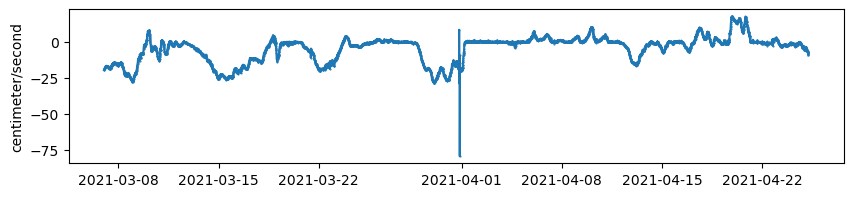

In [9]:
# specify initial and next versions
#===========
v_i = 'v0'
v_f = 'v1' 
#===========

# calculate forward looking velocities and acclerations between reported times
out = calculate_velocity(lons = cleaned['lon'][v_i], lats = cleaned['lat'][v_i], 
                         times = cleaned['time'][v_i], method = 'forward', skip_nans = True, acceleration = True)
u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
cleaned['acc'][v_i] = ACC
cleaned['u'][v_i] = u
cleaned['v'][v_i] = v

fig, ax = plt.subplots(figsize=(10,2))
plt.plot(time, u, marker='.', ms = 1)

### (1b) Acceleration flag

- Remove any points where acclerations are unreasonably large
- Changes in velocity of more than 50 cm/s in an hour

<IPython.core.display.Javascript object>


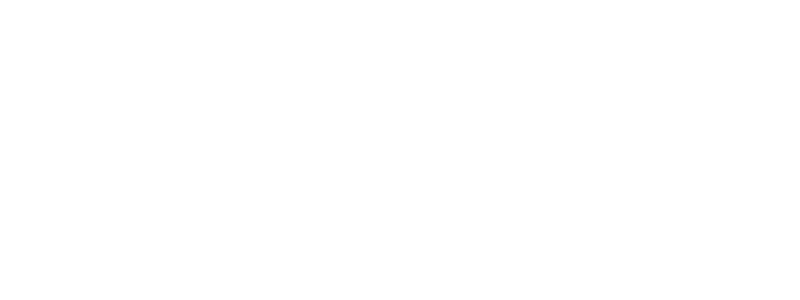

>>> 3 flagged points


In [10]:
%matplotlib notebook
#================================================
a_thresh = 50*units('cm/(s*hr)').to('cm/(s*s)')
acc = cleaned['acc'][v_i]
#================================================

accel_flag = acceleration_flag(acc, time, thresh = a_thresh, show_plot = True)
print(f'>>> {len(accel_flag)} flagged points')

### (1c) Velocity flag

<IPython.core.display.Javascript object>


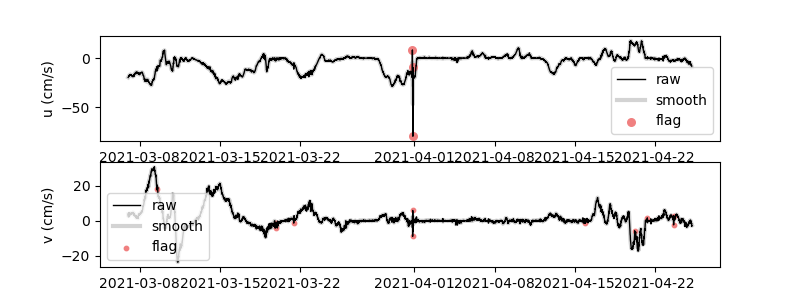

>>> 14 flagged points


In [11]:
%matplotlib notebook
#===============================
U = cleaned['u'][v_i].magnitude
V = cleaned['v'][v_i].magnitude
#===============================

vel_flag = velocity_flag(U, V, time, Nstd = 5, show_plot = True)
print(f'>>> {len(vel_flag)} flagged points')

### (1d) Coordinate flag

<IPython.core.display.Javascript object>


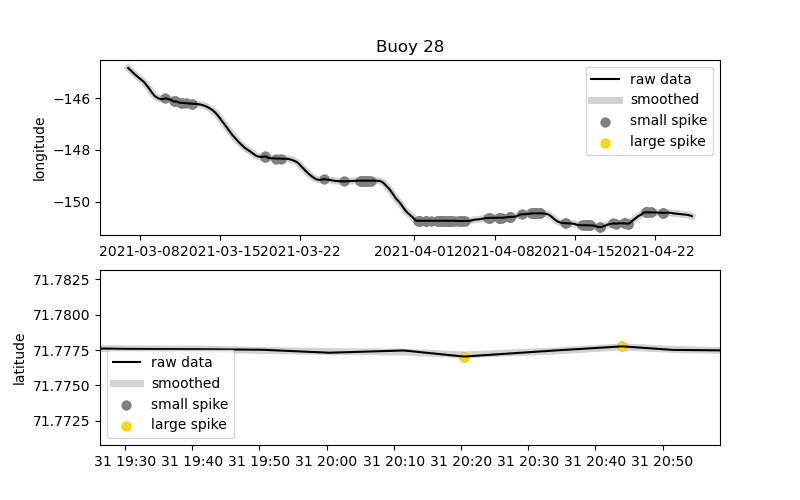

>>> 2 flagged points


In [12]:
#===============================
t = cleaned['time'][v_i]
lon = cleaned['lon'][v_i]
lat = cleaned['lat'][v_i]

allowed_dp = 1000*units('cm')
#===============================
# dt = 10*units('minute').to('s')
# vel_error = allowed_dp/dt
# print(vel_error)

coord_flag = coordinate_flag(lon, lat, t, allowed_dp = allowed_dp, show_plot = True)
print(f'>>> {len(coord_flag)} flagged points')

### (1e) Combine all flags

<IPython.core.display.Javascript object>


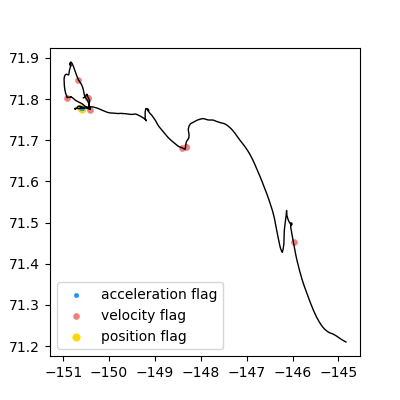

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

t = cleaned['time'][v_i]
x = cleaned['lon'][v_i]
y = cleaned['lat'][v_i]

ax.plot(x,y,c='k', lw=1, zorder=3)

# ax.scatter(x[flag_accel], y[flag_accel],linewidth=0.3, s=30, c='r', zorder=1)
ax.scatter(x[accel_flag], y[accel_flag],linewidth=0.3, s=10, c='dodgerblue', zorder=2, label='acceleration flag')
ax.scatter(x[vel_flag], y[vel_flag],linewidth=0.3, s=20, c='lightcoral', zorder=1, label='velocity flag')
ax.scatter(x[coord_flag], y[coord_flag],linewidth=0.3, s=30, c='gold', zorder=1, label='position flag')
ax.legend();

### Remove flagged values

In [14]:
all_flag = np.unique(np.append(np.append(accel_flag,vel_flag),coord_flag))
cleaned['flag'][v_i] = all_flag
per_flagged = 100*len(all_flag)/len(x)
print(f'{per_flagged:.2f}% of data was flagged')

# save next iteration
# fill bad lats/lons with nans
cleaned['time'][v_f] = np.delete(pd.to_datetime(np.copy(cleaned['time'][v_i])), all_flag)
cleaned['lat'][v_f] = np.delete(np.copy(cleaned['lat'][v_i]), all_flag)
cleaned['lon'][v_f] = np.delete(np.copy(cleaned['lon'][v_i]), all_flag)

0.21% of data was flagged


## Iteration 2
Create function to run in bulk

In [31]:
def run_altogether(cleaned, v_i = 'v0', v_f = 'v1', show_plot = True, plot_frac = 1):
    
    # calculate forward looking velocities and acclerations between reported times
    out = calculate_velocity(lons = cleaned['lon'][v_i], lats = cleaned['lat'][v_i], 
                             times = cleaned['time'][v_i], method = 'forward', skip_nans = True, acceleration = True)
    u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
    cleaned['acc'][v_i] = ACC
    cleaned['u'][v_i] = u
    cleaned['v'][v_i] = v
#     fig, ax = plt.subplots(figsize=(6,1))
#     plt.plot(time, u, marker='.', ms = 1)
    
    #================================
    acc = cleaned['acc'][v_i]
    U = cleaned['u'][v_i].magnitude
    V = cleaned['v'][v_i].magnitude
    t = cleaned['time'][v_i]
    lon = cleaned['lon'][v_i]
    lat = cleaned['lat'][v_i]
    #===============================
    
    # create flags
    accel_flag = acceleration_flag(acc, time, thresh = a_thresh, show_plot = show_plot, plot_frac = plot_frac)
    print(f'>>> {len(accel_flag)} flagged acceleration points')
    vel_flag = velocity_flag(U, V, time, Nstd = 10, show_plot = show_plot, plot_frac = plot_frac)
    print(f'>>> {len(vel_flag)} flagged velocity points')
    coord_flag = coordinate_flag(lon, lat, t, allowed_dp = allowed_dp, show_plot = show_plot, plot_frac = plot_frac)
    print(f'>>> {len(coord_flag)} flagged coordinate points')
    all_flag = np.unique(np.append(np.append(accel_flag,vel_flag),coord_flag))
    cleaned['flag'][v_i] = all_flag
    per_flagged = 100*len(all_flag)/len(x)
    print(f'{per_flagged:.2f}% of data was flagged')
    
    # save next iteration
    # fill bad lats/lons with nans
    cleaned['time'][v_f] = np.delete(pd.to_datetime(np.copy(cleaned['time'][v_i])), all_flag)
    cleaned['lat'][v_f] = np.delete(np.copy(cleaned['lat'][v_i]), all_flag)
    cleaned['lon'][v_f] = np.delete(np.copy(cleaned['lon'][v_i]), all_flag)
    
    return cleaned

v1 >>> v2


<IPython.core.display.Javascript object>


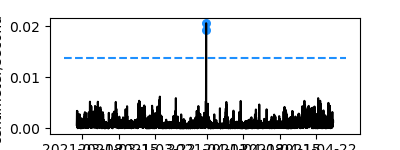

>>> 2 flagged acceleration points


<IPython.core.display.Javascript object>


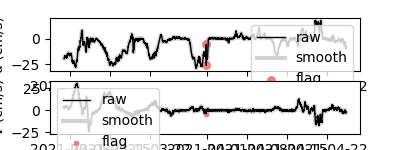

>>> 3 flagged velocity points


<IPython.core.display.Javascript object>


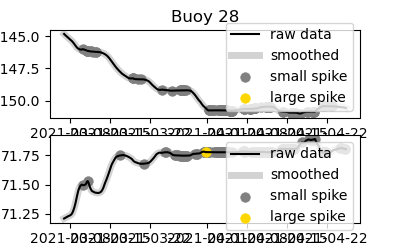

>>> 1 flagged coordinate points
0.06% of data was flagged
v2 >>> v3
>>> 0 flagged acceleration points


<IPython.core.display.Javascript object>


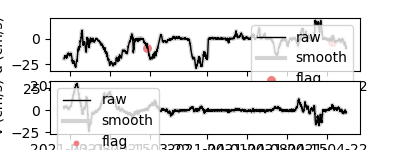

>>> 2 flagged velocity points
>>> 0 flagged coordinate points
0.03% of data was flagged
v3 >>> v4
>>> 0 flagged acceleration points


<IPython.core.display.Javascript object>


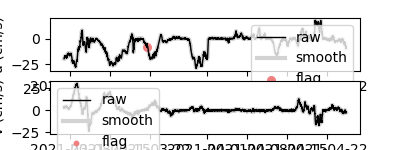

>>> 1 flagged velocity points
>>> 0 flagged coordinate points
0.01% of data was flagged
v4 >>> v5
>>> 0 flagged acceleration points
>>> 0 flagged velocity points
>>> 0 flagged coordinate points
0.00% of data was flagged


In [22]:
iteration = 0

# specify initial and next versions
#===========
v_i = 'v1'
v_f = 'v2' 
#===========
    
# run up to 5 times, or until previous version had no flags
while (len(cleaned['flag'][f'v{int(v_i[-1])-1}']) > 0) and iteration < 5:
    
    print(f'\n{v_i} >>> {v_f}')
      
    cleaned = run_altogether(cleaned, v_i = v_i, v_f = v_f, plot_frac = 0.5)
    
    # next iteration
    v_i = v_f
    v_f = f'v{int(v_f[-1])+1}'
    
    iteration += 1

In [36]:
data_di = {}

for file in csv_files:

    # grab buoy num
    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    print(f'\n=========\nbuoy {buoy_num}\n=========')

    # open raw data
    df = pd.read_csv(file)
    raw_dates = pd.to_datetime(df.datetime.values)
    raw_lat = df.latitude.values
    raw_lon = df.longitude.values

    # create data dictionary for specific buoy
    data_di[buoy_num] = {}
    data_di[buoy_num]['lat'] = {}
    data_di[buoy_num]['lon'] = {}
    data_di[buoy_num]['time'] = {}
    data_di[buoy_num]['acc'] = {}
    data_di[buoy_num]['u'] = {}
    data_di[buoy_num]['v'] = {}
    data_di[buoy_num]['flag'] = {}
    
    # fill in first version
    data_di[buoy_num]['lat']['v0'] = raw_lat
    data_di[buoy_num]['lon']['v0'] = raw_lon
    data_di[buoy_num]['time']['v0'] = raw_dates
    

    # specify initial and next versions
    v_i = 'v0'
    v_f = 'v1' 
    iteration = 0
    
    # run up to 5 times, or until previous version had no flags
    while iteration <= 5:

        print(f'\n{v_i} >>> {v_f}')

        data_di[buoy_num] = run_altogether(data_di[buoy_num], v_i = v_i, v_f = v_f, show_plot = False, plot_frac = 0.5)

        if len(cleaned['flag'][v_i]) == 0:
            break
        
        # next iteration
        v_i = v_f
        v_f = f'v{int(v_f[-1])+1}'

        iteration += 1

buoy 23

v0 >>> v1
>>> 48 flagged acceleration points
>>> 23 flagged velocity points
>>> 15 flagged coordinate points
0.79% of data was flagged

v1 >>> v2
>>> 0 flagged acceleration points
>>> 45 flagged velocity points
>>> 7 flagged coordinate points
0.73% of data was flagged

v2 >>> v3
>>> 0 flagged acceleration points
>>> 28 flagged velocity points
>>> 5 flagged coordinate points
0.48% of data was flagged

v3 >>> v4
>>> 0 flagged acceleration points
>>> 9 flagged velocity points
>>> 5 flagged coordinate points
0.21% of data was flagged

v4 >>> v5
>>> 0 flagged acceleration points
>>> 0 flagged velocity points
>>> 4 flagged coordinate points
0.06% of data was flagged
buoy 24

v0 >>> v1
>>> 5 flagged acceleration points
>>> 37 flagged velocity points
>>> 0 flagged coordinate points
0.56% of data was flagged

v1 >>> v2
>>> 1 flagged acceleration points
>>> 15 flagged velocity points
>>> 1 flagged coordinate points
0.25% of data was flagged

v2 >>> v3
>>> 0 flagged acceleration points
>

>>> 0 flagged acceleration points
>>> 0 flagged velocity points
>>> 0 flagged coordinate points
0.00% of data was flagged
buoy 34_2

v0 >>> v1
>>> 2 flagged acceleration points
>>> 15 flagged velocity points
>>> 0 flagged coordinate points
0.23% of data was flagged

v1 >>> v2
>>> 0 flagged acceleration points
>>> 3 flagged velocity points
>>> 0 flagged coordinate points
0.04% of data was flagged

v2 >>> v3
>>> 1 flagged acceleration points
>>> 2 flagged velocity points
>>> 1 flagged coordinate points
0.04% of data was flagged

v3 >>> v4
>>> 1 flagged acceleration points
>>> 2 flagged velocity points
>>> 1 flagged coordinate points
0.03% of data was flagged

v4 >>> v5
>>> 0 flagged acceleration points
>>> 2 flagged velocity points
>>> 1 flagged coordinate points
0.03% of data was flagged
buoy 35

v0 >>> v1
>>> 116 flagged acceleration points
>>> 25 flagged velocity points
>>> 38 flagged coordinate points
1.94% of data was flagged

v1 >>> v2
>>> 0 flagged acceleration points
>>> 10 flagg

>>> 0 flagged acceleration points
>>> 1 flagged velocity points
>>> 0 flagged coordinate points
0.01% of data was flagged

v4 >>> v5
>>> 0 flagged acceleration points
>>> 0 flagged velocity points
>>> 0 flagged coordinate points
0.00% of data was flagged
buoy 46

v0 >>> v1
>>> 10 flagged acceleration points
>>> 9 flagged velocity points
>>> 5 flagged coordinate points
0.22% of data was flagged

v1 >>> v2
>>> 2 flagged acceleration points
>>> 19 flagged velocity points
>>> 2 flagged coordinate points
0.28% of data was flagged

v2 >>> v3
>>> 0 flagged acceleration points
>>> 11 flagged velocity points
>>> 0 flagged coordinate points
0.16% of data was flagged

v3 >>> v4
>>> 0 flagged acceleration points
>>> 5 flagged velocity points
>>> 0 flagged coordinate points
0.07% of data was flagged

v4 >>> v5
>>> 0 flagged acceleration points
>>> 1 flagged velocity points
>>> 0 flagged coordinate points
0.01% of data was flagged
buoy 47

v0 >>> v1
>>> 4 flagged acceleration points
>>> 4 flagged ve

<IPython.core.display.Javascript object>


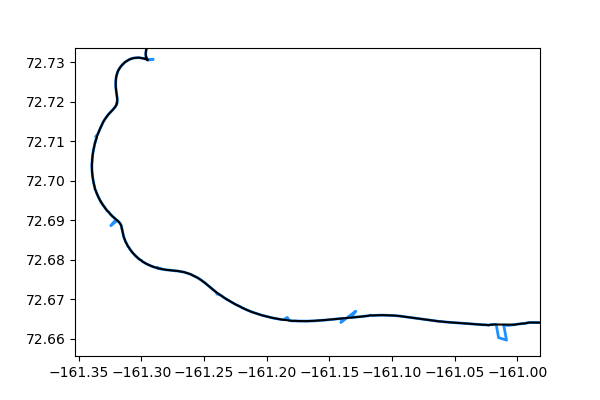

0.9895121456120171


In [52]:
fig, ax = plt.subplots(figsize=(6,4))

buoy_num = '23'

print(len(data_di[buoy_num]['lon']['v5'])/len(data_di[buoy_num]['lon']['v0']))

ax.plot(data_di[buoy_num]['lon']['v0'], data_di[buoy_num]['lat']['v0'], c='dodgerblue', lw=2)
ax.plot(data_di[buoy_num]['lon']['v5'], data_di[buoy_num]['lat']['v5'], c='k')

In [56]:
final_vers = list(data_di[buoy_num]['lon'].keys())[-1]

In [57]:
final_vers

'v5'

In [63]:
len(data_di[buoy_num]['time'][final_vers])

14624

In [ ]:
# open raw data
    df = pd.read_csv(file)
    raw_dates = pd.to_datetime(df.datetime.values)
    raw_lat = df.latitude.values
    raw_lon = df.longitude.values

In [70]:


file_name = './data/BuoyCoordinates/23.csv'
df2.to_csv(file_name, encoding='utf-8', index=False)

In [87]:
for file in csv_files:
    # grab buoy num
    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    print(f'\n=========\nbuoy {buoy_num}\n=========')
    
    
    new_file_name = f"./data/BuoyCoordinates/{file.split('/')[-1].split('.')[0]}_v1.csv"
    print(file)
    print(new_file_name)
    
    # find last version of coordinates
    final_vers = list(data_di[buoy_num]['lon'].keys())[-1]
    print(final_vers)
    
    # create data frame with final version
    d = {'latitude': data_di[buoy_num]['lat'][final_vers], 
         'longitude': data_di[buoy_num]['lon'][final_vers], 
         'datetime': data_di[buoy_num]['time'][final_vers]}
    df2 = pd.DataFrame(data=d)
    
    # save to file
    df2.to_csv(new_file_name, encoding='utf-8', index=False)


buoy 23
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_23_300534061090050.csv
./data/BuoyCoordinates/OSU_IT_23_300534061090050_v1.csv
v5

buoy 24
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
./data/BuoyCoordinates/OSU_IT_24_300534061090090_v1.csv
v5

buoy 25
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_25_300534061091050.csv
./data/BuoyCoordinates/OSU_IT_25_300534061091050_v1.csv
v5

buoy 26
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
./data/BuoyCoordinates/OSU_IT_26_300534061091060_v1.csv
v5

buoy 27
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_27_300534061091070.csv
./data/BuoyCoordinates/OSU_IT_27_300534061091070_v1.csv
v5

buoy 28
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
./data/BuoyCoordinates/OSU_IT_28_300534061093020_v1.csv
v5

buoy 29
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_29_300534061093030.csv
./data/BuoyCoordinates/OSU_IT_

<IPython.core.display.Javascript object>


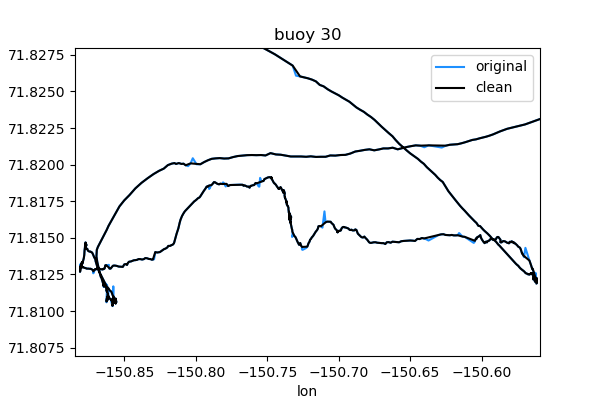

Text(0.5, 1.0, 'buoy 30')

In [97]:
fig, ax = plt.subplots(figsize=(6,4))


# open raw data
df = pd.read_csv('/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_30_300534061093040.csv')

plt.plot(df.longitude.values, df.latitude.values, c='dodgerblue', label='original')


df2 = pd.read_csv('./data/BuoyCoordinates/OSU_IT_30_300534061093040_v1.csv')

plt.plot(df2.longitude.values, df2.latitude.values, c='k', label='clean')
plt.legend()

plt.ylabel('lat')
plt.xlabel('lon')
plt.title('buoy 30')

In [79]:
file.split('/')[-1].split('.')[0]

'OSU_IT_53_300534061988500'

### (1c) Define functions to identify and plot flagged values

### (1e) Remove flagged values
Remove flagged values. This is based on drift track errors seen in plots above

In [11]:
remove_indices = cleaned['flag']['v0']

print(f'>>> removing {len(remove_indices)} flagged values')

cleaned['lon']['v1'] = np.copy(cleaned['lon']['v0'])
cleaned['lat']['v1'] = np.copy(cleaned['lat']['v0'])
cleaned['time']['v1'] = pd.to_datetime(np.copy(cleaned['time']['v0']))

cleaned['lat']['v1'][remove_indices] = np.nan
cleaned['lon']['v1'][remove_indices] = np.nan

no_nan_locs = np.isnan(cleaned['lat']['v1']) == False

cleaned['lat']['v1'] = cleaned['lat']['v1'][no_nan_locs]
cleaned['lon']['v1'] = cleaned['lon']['v1'][no_nan_locs]
cleaned['time']['v1'] = cleaned['time']['v1'][no_nan_locs]



>>> removing 9 flagged values


### (1e) Rinse and repeat until there are no more flags!
Define function to run through whole process of removing nans in bulk

In [12]:
def iterate_cleaning(vi = '', vn = '', buoy_num = '', data_di = {}, 
                     show_velocity = True, show_acceleration = True, show_tracks = True):
    
    # calculate forward looking velocities and accelerations for vi
    #--------------------------------------------------------------
    out = calculate_velocity(lons = data_di['lon'][vi], 
                             lats = data_di['lat'][vi], 
                             times = data_di['time'][vi], 
                             method = 'forward', skip_nans = True, acceleration = True)
    u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
    data_di['acc'][vi] = ACC
    
    if show_velocity:
        fig, ax = plt.subplots(figsize=(8,1))
        plt.title('u')
        plt.plot(time, u)
        plt.show()
    
    # flag values in vi
    #-----------------------------------------------------------
    data_di['flag'][vi] = create_flags(lons = data_di['lon'][vi], 
                                       lats = data_di['lat'][vi], 
                                       acc = data_di['acc'][vi])
    
    if show_acceleration:
        # plot flagged values
        #-----------------------------------------------------------
        # plot accelerations and flagged values timeseries
        l_colors = ['lightgray', 'lightgreen', 'skyblue', 'violet', 'lightcoral', 'gold' ]
        p_colors = ['gray', 'green', 'blue', 'darkmagenta', 'red',  'darkorange']

        fig, ax = plt.subplots(figsize=(10,2))
        plt.title(f'Acceleration vector magnitude (Buoy {buoy_num})')
        plt.ylim(0,0.1)
        for vv in range(int(vn[1:])):
            ver = f'v{vv}'
    #     for vv, ver in enumerate(['v0', 'v1']):
            plot_accelerations(fig, ax, 
                               time = data_di['time'][ver][:-1], 
                               acc  = data_di['acc'][ver], 
                               flag = data_di['flag'][ver], linecolor=l_colors[vv], flagcolor=p_colors[vv])
        plt.show()
    
    if show_tracks:
        # plot drift tracks for individual flags
        plot_flagtracks(lons = data_di['lon'][vi], 
                        lats = data_di['lat'][vi], 
                        flag = data_di['flag'][vi], 
                        acc  = data_di['acc'][vi],
                        lat_range = 0.003, lon_range = 0.01, buffer = 30)

    
    # remove flagged values
    #-----------------------------------------------------------
    remove_indices = data_di['flag'][vi]

    print(f'>>> removing {len(remove_indices)} flagged values')

    data_di['lon'][vn] = np.copy(data_di['lon'][vi])
    data_di['lat'][vn] = np.copy(data_di['lat'][vi])
    data_di['time'][vn] = pd.to_datetime(np.copy(data_di['time'][vi]))

    data_di['lat'][vn][remove_indices] = np.nan
    data_di['lon'][vn][remove_indices] = np.nan

    no_nan_locs = np.isnan(data_di['lat'][vn]) == False

    data_di['lat'][vn] = data_di['lat'][vn][no_nan_locs]
    data_di['lon'][vn] = data_di['lon'][vn][no_nan_locs]
    data_di['time'][vn] = data_di['time'][vn][no_nan_locs]
    
    return data_di

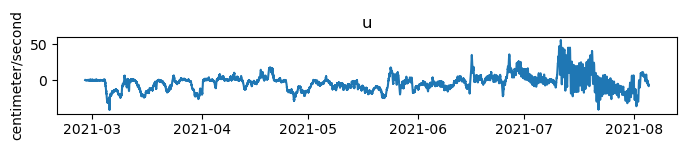

0.04 % of the data is flagged
0.00 % of the data is flagged


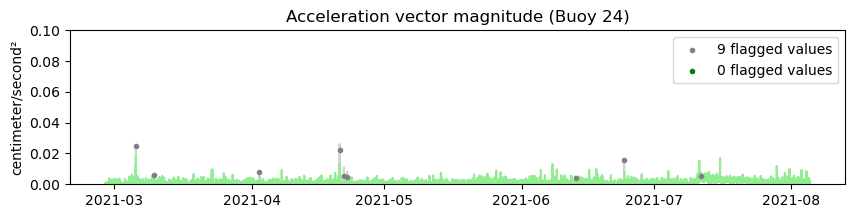

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values


In [13]:
# specify current and next versions
#==================================
vi = 'v1'
vn = 'v2'
#==================================

cleaned = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = cleaned)

# Run iteratively on second file

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
buoy 26

v0  >>>  v1


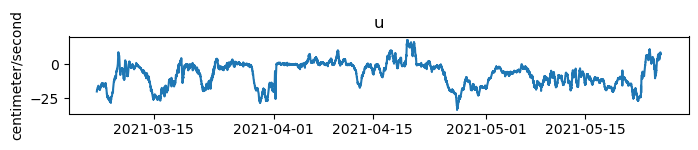

0.18 % of the data is flagged


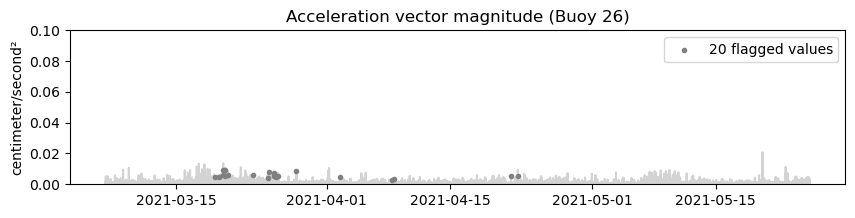

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1786 2021-03-19 09:10:26 0.00449 centimeter / second ** 2


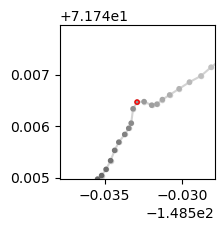

1846 2021-03-19 19:10:26 0.00469 centimeter / second ** 2


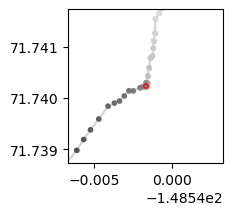

1912 2021-03-20 06:10:26 0.00574 centimeter / second ** 2


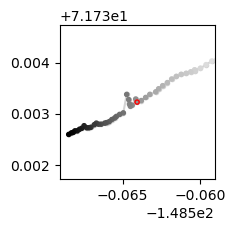

1918 2021-03-20 07:10:26 0.00926 centimeter / second ** 2


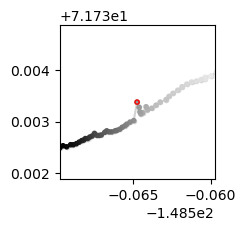

1950 2021-03-20 12:30:25 0.00565 centimeter / second ** 2


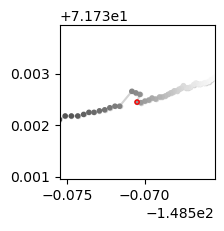

1953 2021-03-20 13:00:28 0.00923 centimeter / second ** 2


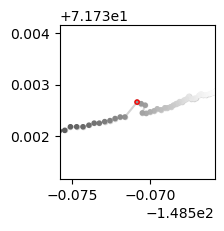

1991 2021-03-20 19:20:31 0.00572 centimeter / second ** 2


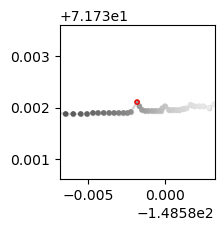

2406 2021-03-23 16:30:26 0.00601 centimeter / second ** 2


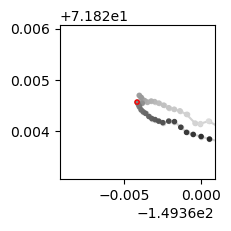

2647 2021-03-25 08:40:26 0.00436 centimeter / second ** 2


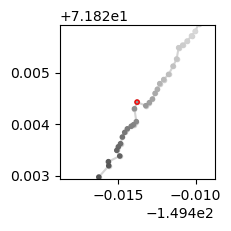

2659 2021-03-25 10:40:26 0.00770 centimeter / second ** 2


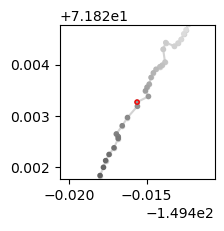

2740 2021-03-26 00:10:27 0.00707 centimeter / second ** 2


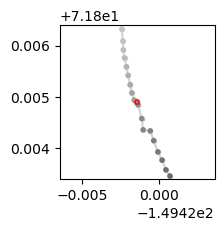

2743 2021-03-26 00:40:26 0.00567 centimeter / second ** 2


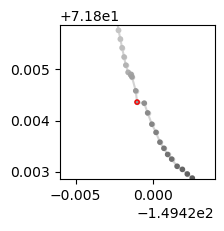

2773 2021-03-26 05:40:26 0.00500 centimeter / second ** 2


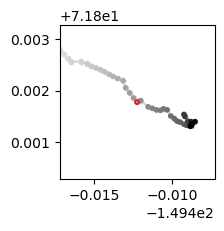

2802 2021-03-26 10:40:27 0.00542 centimeter / second ** 2


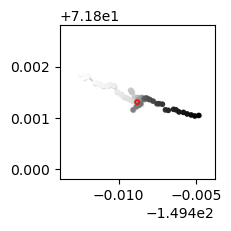

3075 2021-03-28 13:50:26 0.00831 centimeter / second ** 2


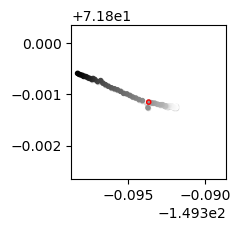

3776 2021-04-02 11:40:26 0.00449 centimeter / second ** 2


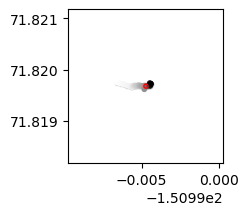

4552 2021-04-08 10:20:26 0.00290 centimeter / second ** 2


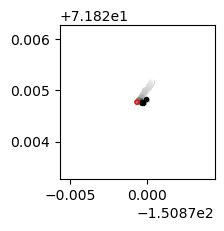

4579 2021-04-08 15:30:26 0.00321 centimeter / second ** 2


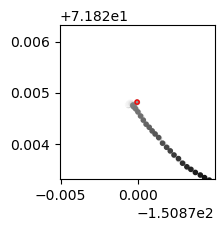

6429 2021-04-21 20:20:28 0.00555 centimeter / second ** 2


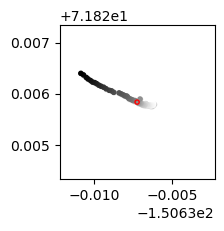

6540 2021-04-22 15:00:28 0.00556 centimeter / second ** 2


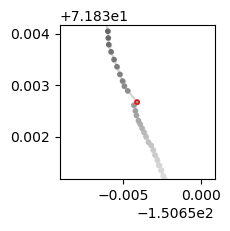

>>> removing 20 flagged values
v1  >>>  v2


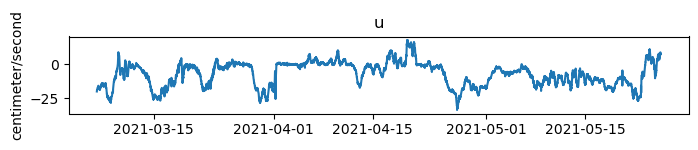

0.18 % of the data is flagged
0.04 % of the data is flagged


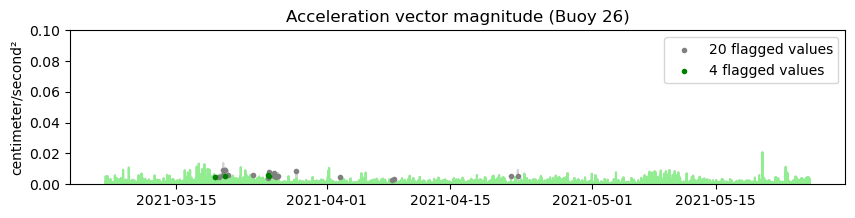

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1786 2021-03-19 09:10:26 0.00484 centimeter / second ** 2


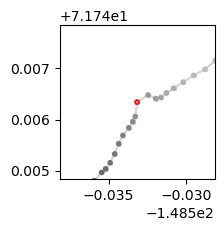

1946 2021-03-20 11:50:25 0.00545 centimeter / second ** 2


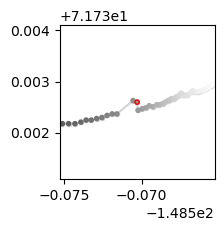

2639 2021-03-25 07:20:25 0.00592 centimeter / second ** 2


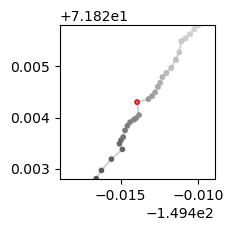

2648 2021-03-25 08:50:26 0.00530 centimeter / second ** 2


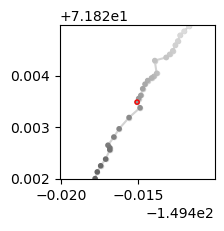

>>> removing 4 flagged values
v2  >>>  v3


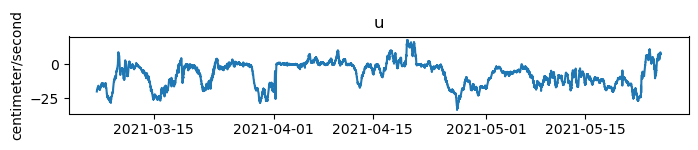

0.18 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


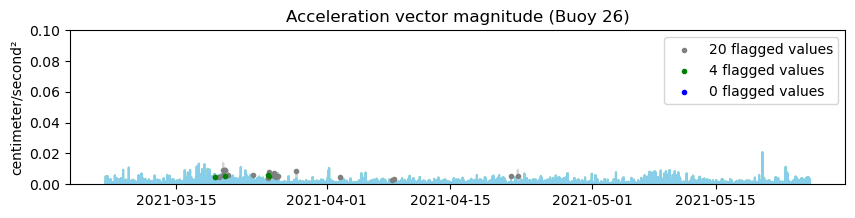

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values


In [14]:
file = csv_files[3]
print(file)

# grab buoy num
buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
print(f'buoy {buoy_num}\n')

df = pd.read_csv(file)
raw_dates = pd.to_datetime(df.datetime.values)
raw_lat = df.latitude.values
raw_lon = df.longitude.values

cleaned = {}
cleaned['lat'] = {}
cleaned['lon'] = {}
cleaned['time'] = {}
cleaned['acc'] = {}
cleaned['flag'] = {}

cleaned['lat']['v0'] = raw_lat
cleaned['lon']['v0'] = raw_lon
cleaned['time']['v0'] = raw_dates


iterations = 0
num_flags = 100

while (iterations < 6) and (num_flags > 0):
    
    # specify current and next versions
    #==================================
    vi = f'v{iterations}'
    vn = f'v{iterations+1}'
    #==================================
    print(f'{vi}  >>>  {vn}')
    
    # run cleaning
    cleaned = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = cleaned)
    
    # find flags from vi used to create vf
    latest_flags = cleaned['flag'][vi]
    num_flags = len(latest_flags)

    iterations+=1

# Run in bulk across files!!!

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_23_300534061090050.csv
buoy 23


v0  >>>  v1
0.29 % of the data is flagged


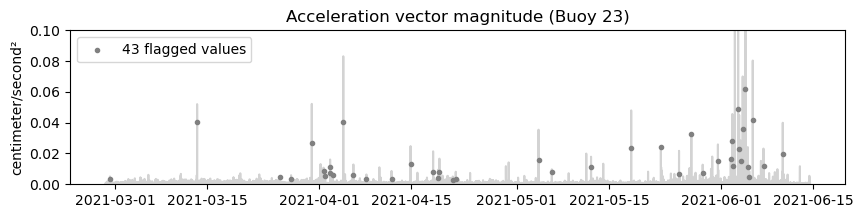

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

77 2021-02-28 05:30:25 0.00365 centimeter / second ** 2


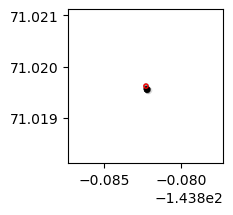

1859 2021-03-13 11:14:00 0.04024 centimeter / second ** 2


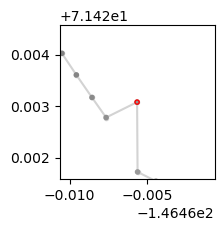

3662 2021-03-26 00:10:26 0.00466 centimeter / second ** 2


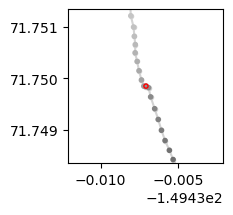

3890 2021-03-27 17:30:26 0.00372 centimeter / second ** 2


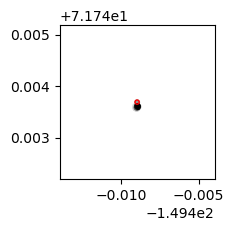

4329 2021-03-30 21:00:32 0.02689 centimeter / second ** 2


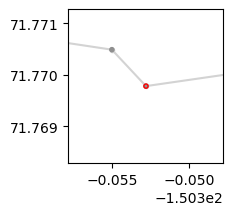

4585 2021-04-01 15:50:33 0.00874 centimeter / second ** 2


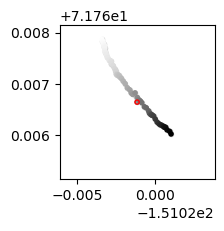

4621 2021-04-01 21:50:27 0.00551 centimeter / second ** 2


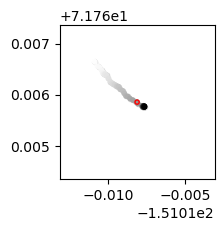

4705 2021-04-02 15:30:26 0.00714 centimeter / second ** 2


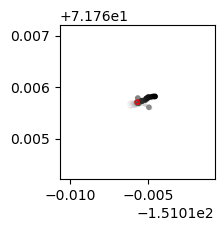

4707 2021-04-02 15:50:33 0.01102 centimeter / second ** 2


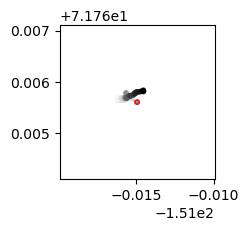

4748 2021-04-03 00:50:25 0.00620 centimeter / second ** 2


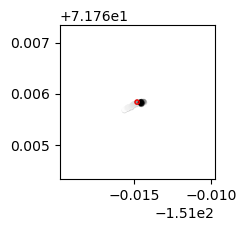

4932 2021-04-04 15:50:25 0.04045 centimeter / second ** 2


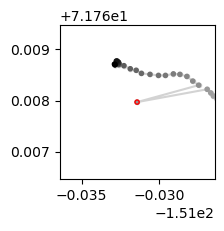

5128 2021-04-06 04:40:29 0.00620 centimeter / second ** 2


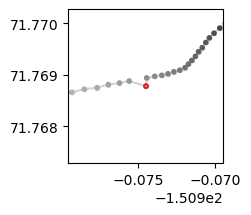

5405 2021-04-08 04:10:31 0.00362 centimeter / second ** 2


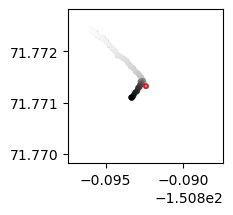

5920 2021-04-11 23:40:26 0.00331 centimeter / second ** 2


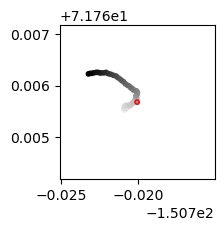

6334 2021-04-14 21:00:25 0.01294 centimeter / second ** 2


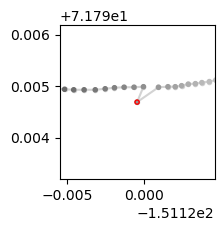

6824 2021-04-18 07:10:26 0.00823 centimeter / second ** 2


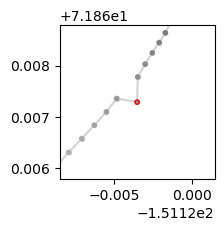

6936 2021-04-19 01:50:25 0.00401 centimeter / second ** 2


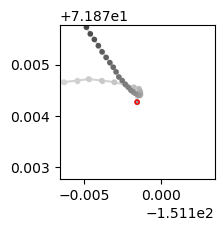

6962 2021-04-19 06:10:26 0.00781 centimeter / second ** 2


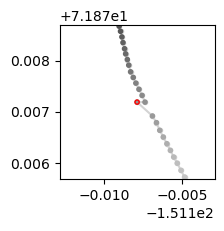

7249 2021-04-21 06:50:31 0.00306 centimeter / second ** 2


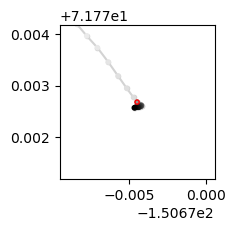

7300 2021-04-21 17:40:26 0.00341 centimeter / second ** 2


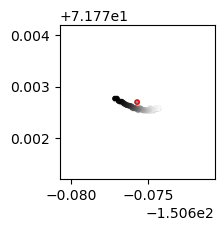

9108 2021-05-04 07:20:28 0.01570 centimeter / second ** 2


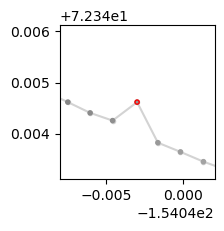

9398 2021-05-06 07:40:27 0.00802 centimeter / second ** 2


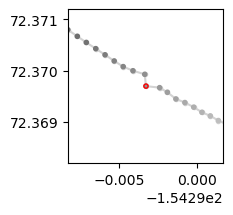

10253 2021-05-12 06:40:24 0.01090 centimeter / second ** 2


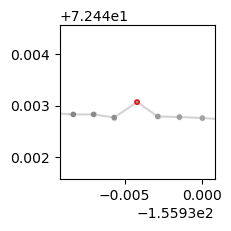

11130 2021-05-18 09:00:26 0.02326 centimeter / second ** 2


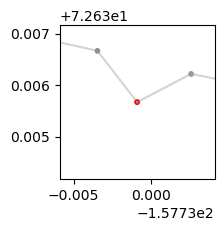

11778 2021-05-22 21:00:26 0.02438 centimeter / second ** 2


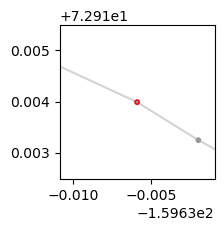

12176 2021-05-25 15:20:27 0.00658 centimeter / second ** 2


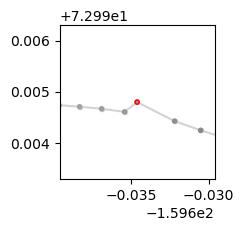

12444 2021-05-27 12:00:26 0.03268 centimeter / second ** 2


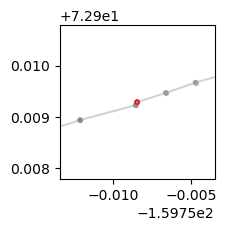

12693 2021-05-29 05:30:28 0.00746 centimeter / second ** 2


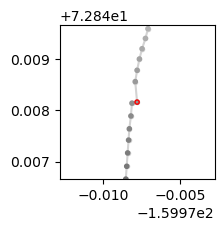

13025 2021-05-31 13:00:33 0.01490 centimeter / second ** 2


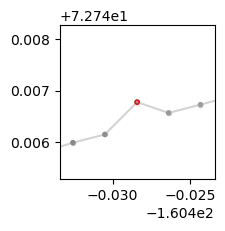

13304 2021-06-02 11:40:35 0.01621 centimeter / second ** 2


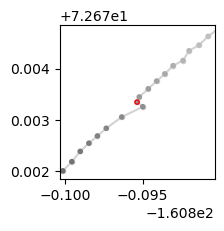

13339 2021-06-02 17:30:29 0.02794 centimeter / second ** 2


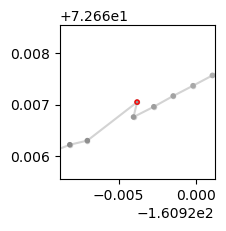

13346 2021-06-02 18:40:32 0.01204 centimeter / second ** 2


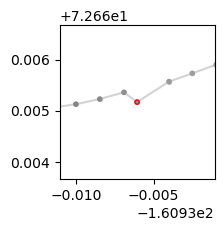

13396 2021-06-03 03:00:36 0.10679 centimeter / second ** 2


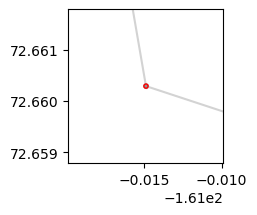

13466 2021-06-03 14:50:29 0.04885 centimeter / second ** 2


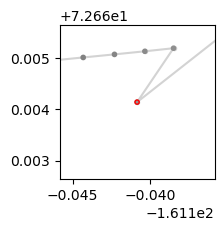

13488 2021-06-03 18:30:33 0.02310 centimeter / second ** 2


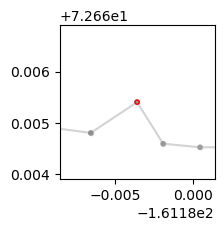

13518 2021-06-03 23:30:28 0.01482 centimeter / second ** 2


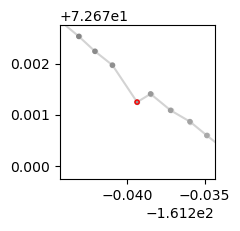

13565 2021-06-04 07:20:36 0.03592 centimeter / second ** 2


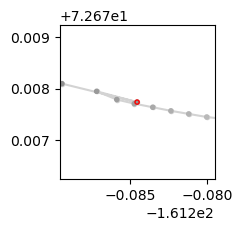

13625 2021-06-04 17:20:34 0.06168 centimeter / second ** 2


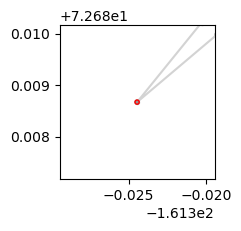

13677 2021-06-05 02:00:30 0.01127 centimeter / second ** 2


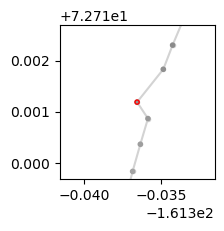

13709 2021-06-05 07:20:36 0.00458 centimeter / second ** 2


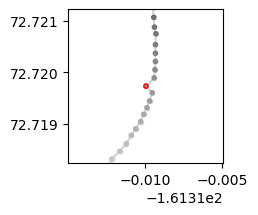

13785 2021-06-05 20:00:33 0.04154 centimeter / second ** 2


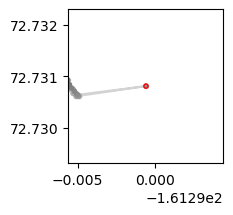

14019 2021-06-07 11:00:27 0.01176 centimeter / second ** 2


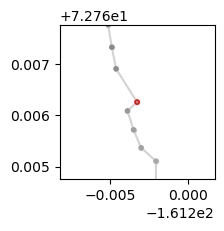

14439 2021-06-10 09:20:38 0.01993 centimeter / second ** 2


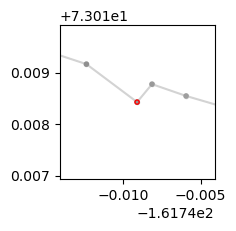

>>> removing 43 flagged values

v1  >>>  v2
0.29 % of the data is flagged
0.03 % of the data is flagged


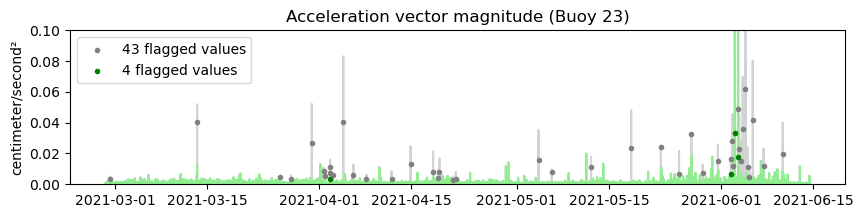

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

4699 2021-04-02 14:10:25 0.00343 centimeter / second ** 2


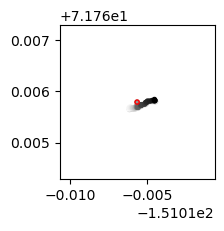

13274 2021-06-02 06:40:28 0.00683 centimeter / second ** 2


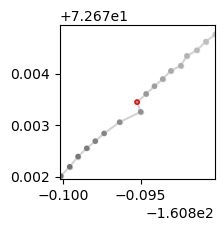

13363 2021-06-02 21:30:27 0.03321 centimeter / second ** 2


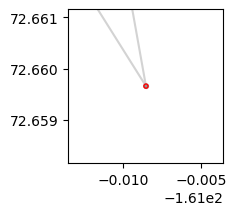

13432 2021-06-03 09:00:26 0.01752 centimeter / second ** 2


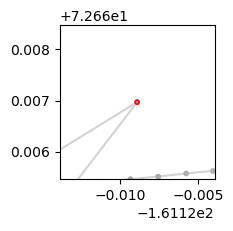

>>> removing 4 flagged values

v2  >>>  v3
0.29 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


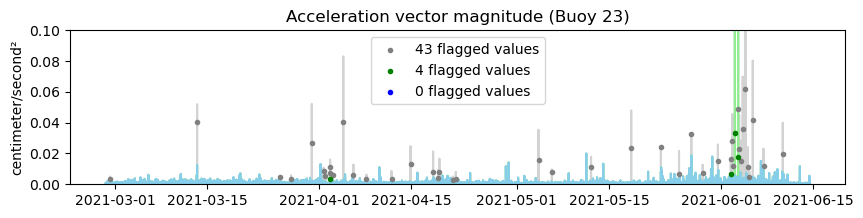

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
buoy 24


v0  >>>  v1
0.04 % of the data is flagged


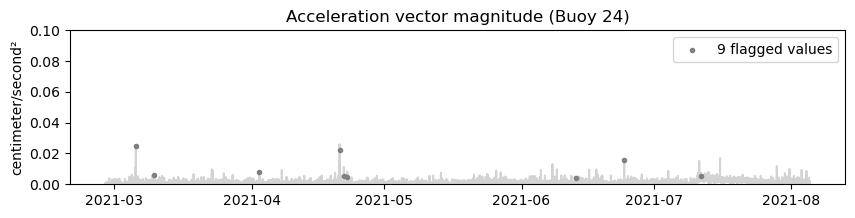

>>> removing 9 flagged values

v1  >>>  v2
0.04 % of the data is flagged
0.00 % of the data is flagged


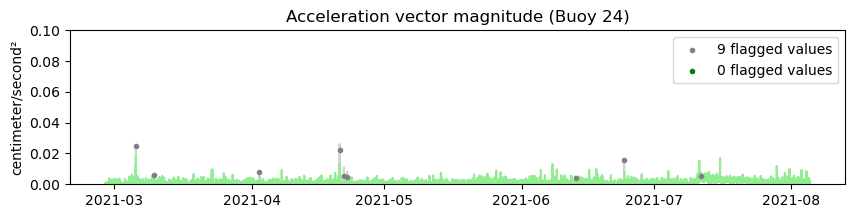

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_25_300534061091050.csv
buoy 25


v0  >>>  v1
0.72 % of the data is flagged


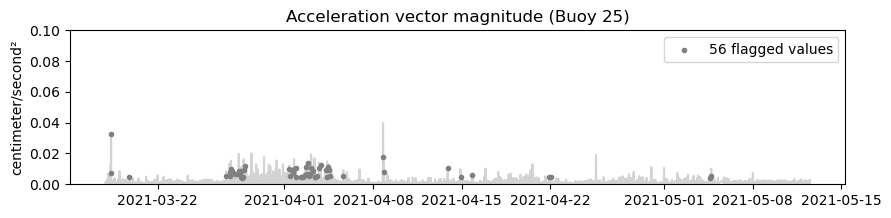

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

60 2021-03-18 07:00:25 0.00753 centimeter / second ** 2


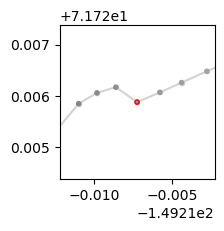

63 2021-03-18 07:34:03 0.03253 centimeter / second ** 2


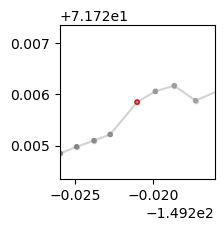

267 2021-03-19 17:30:26 0.00462 centimeter / second ** 2


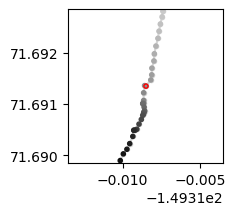

1362 2021-03-27 10:00:26 0.00555 centimeter / second ** 2


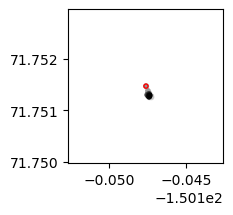

1394 2021-03-27 16:10:26 0.00566 centimeter / second ** 2


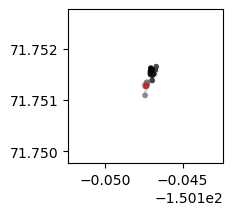

1396 2021-03-27 16:30:26 0.00784 centimeter / second ** 2


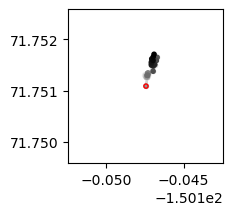

1411 2021-03-27 19:00:33 0.00998 centimeter / second ** 2


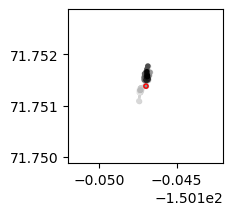

1426 2021-03-27 21:40:28 0.00831 centimeter / second ** 2


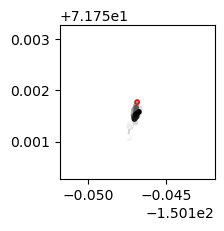

1458 2021-03-28 03:00:30 0.00651 centimeter / second ** 2


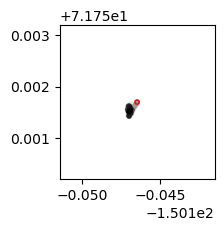

1481 2021-03-28 07:00:31 0.00659 centimeter / second ** 2


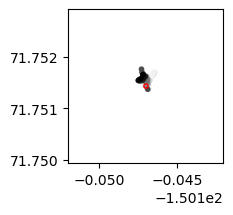

1497 2021-03-28 09:50:38 0.00869 centimeter / second ** 2


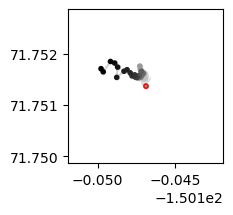

1508 2021-03-28 11:40:27 0.00712 centimeter / second ** 2


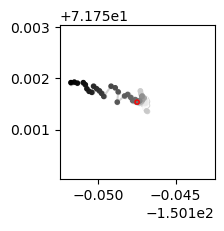

1521 2021-03-28 13:50:28 0.00444 centimeter / second ** 2


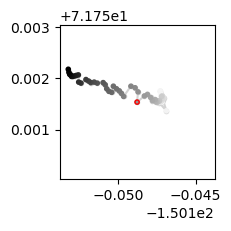

1524 2021-03-28 14:20:28 0.00864 centimeter / second ** 2


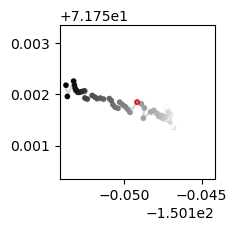

1529 2021-03-28 15:10:27 0.00437 centimeter / second ** 2


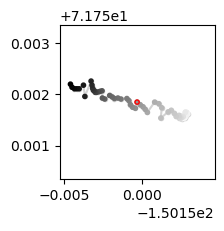

1541 2021-03-28 17:10:30 0.00482 centimeter / second ** 2


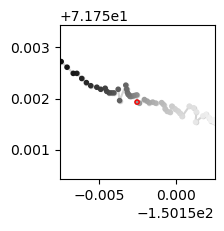

1552 2021-03-28 19:00:32 0.00927 centimeter / second ** 2


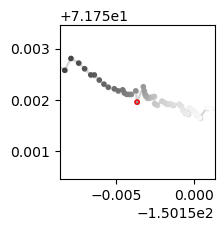

1568 2021-03-28 21:40:27 0.01215 centimeter / second ** 2


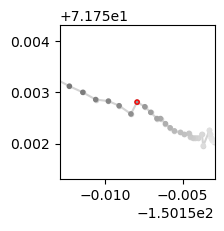

2070 2021-04-01 09:20:27 0.01016 centimeter / second ** 2


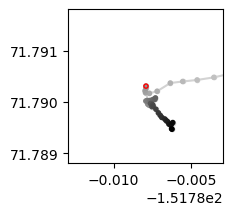

2080 2021-04-01 11:00:26 0.00525 centimeter / second ** 2


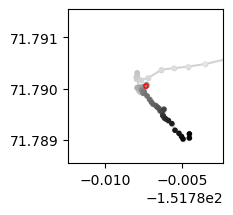

2108 2021-04-01 15:40:27 0.00772 centimeter / second ** 2


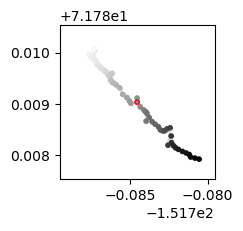

2114 2021-04-01 16:40:30 0.00728 centimeter / second ** 2


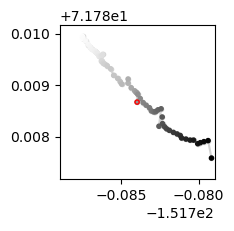

2126 2021-04-01 18:40:32 0.00994 centimeter / second ** 2


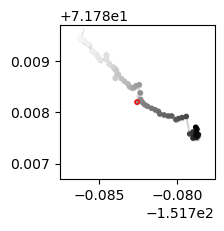

2142 2021-04-01 21:20:27 0.01089 centimeter / second ** 2


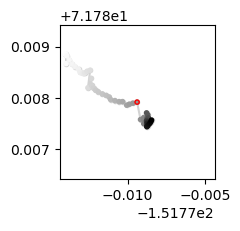

2152 2021-04-01 23:00:28 0.00499 centimeter / second ** 2


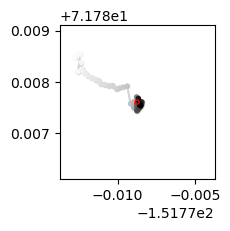

2209 2021-04-02 08:30:54 0.00497 centimeter / second ** 2


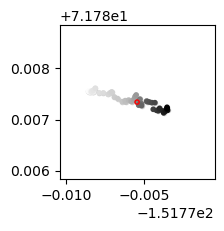

2225 2021-04-02 11:10:26 0.00461 centimeter / second ** 2


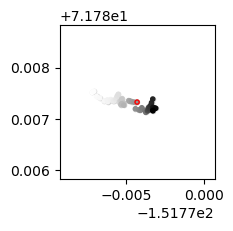

2247 2021-04-02 14:50:28 0.00573 centimeter / second ** 2


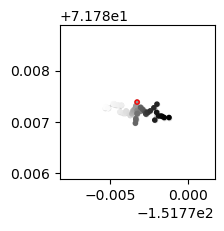

2257 2021-04-02 16:30:28 0.01096 centimeter / second ** 2


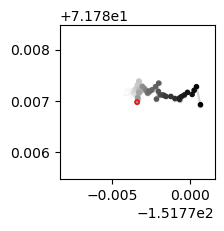

2270 2021-04-02 18:40:31 0.00690 centimeter / second ** 2


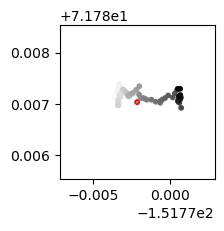

2285 2021-04-02 21:10:28 0.01387 centimeter / second ** 2


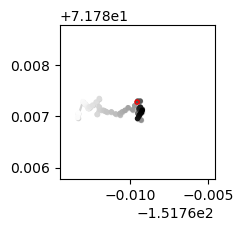

2299 2021-04-02 23:30:28 0.00511 centimeter / second ** 2


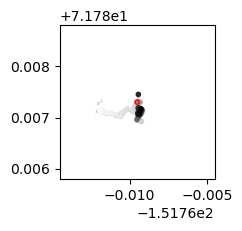

2307 2021-04-03 00:50:26 0.00642 centimeter / second ** 2


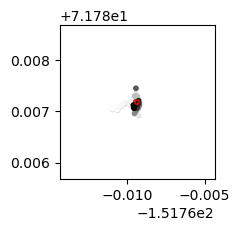

2320 2021-04-03 03:00:30 0.01081 centimeter / second ** 2


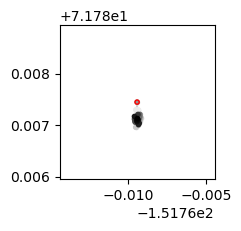

2343 2021-04-03 07:00:28 0.00861 centimeter / second ** 2


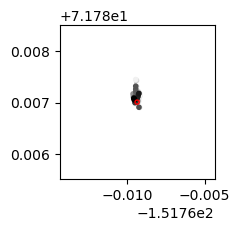

2358 2021-04-03 09:30:31 0.00462 centimeter / second ** 2


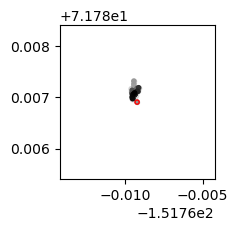

2367 2021-04-03 11:00:26 0.00469 centimeter / second ** 2


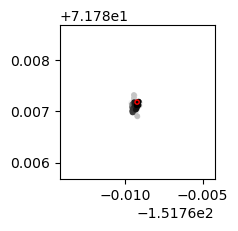

2390 2021-04-03 14:50:26 0.00524 centimeter / second ** 2


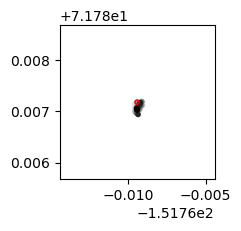

2412 2021-04-03 18:30:31 0.01059 centimeter / second ** 2


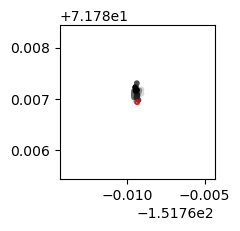

2427 2021-04-03 21:10:28 0.01227 centimeter / second ** 2


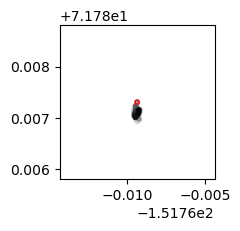

2480 2021-04-04 06:10:27 0.00914 centimeter / second ** 2


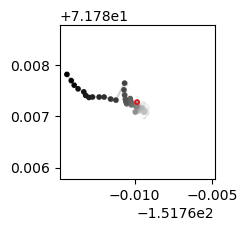

2491 2021-04-04 08:10:27 0.00470 centimeter / second ** 2


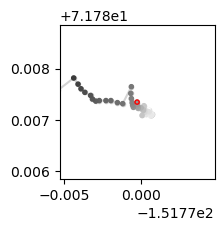

2497 2021-04-04 09:10:29 0.01019 centimeter / second ** 2


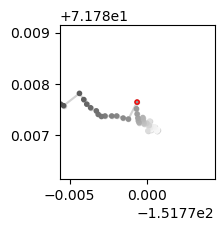

2509 2021-04-04 11:10:28 0.01130 centimeter / second ** 2


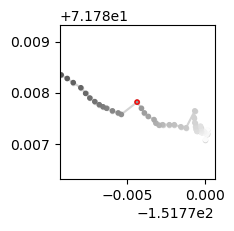

2523 2021-04-04 13:30:30 0.00950 centimeter / second ** 2


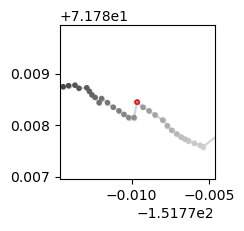

2530 2021-04-04 14:40:27 0.00564 centimeter / second ** 2


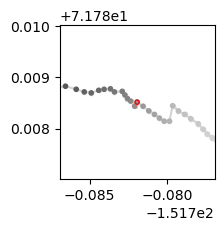

2658 2021-04-05 16:00:25 0.00508 centimeter / second ** 2


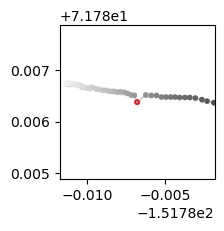

3085 2021-04-08 19:20:27 0.01793 centimeter / second ** 2


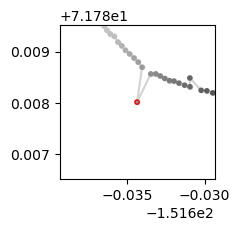

3095 2021-04-08 21:00:26 0.00799 centimeter / second ** 2


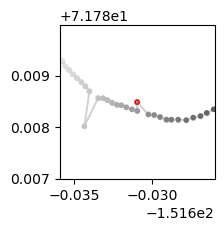

3798 2021-04-13 21:50:25 0.01086 centimeter / second ** 2


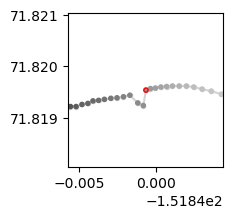

3940 2021-04-14 22:00:31 0.00460 centimeter / second ** 2


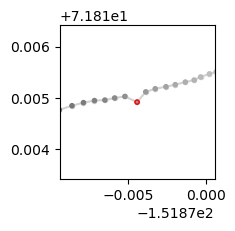

4065 2021-04-15 19:40:28 0.00582 centimeter / second ** 2


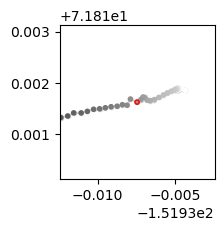

4933 2021-04-21 21:50:26 0.00493 centimeter / second ** 2


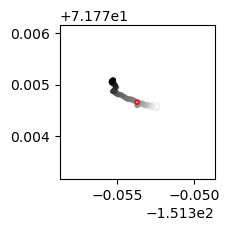

4951 2021-04-22 00:50:26 0.00442 centimeter / second ** 2


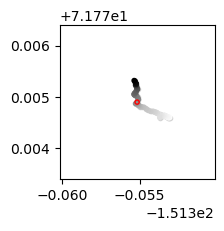

6762 2021-05-04 15:00:25 0.00419 centimeter / second ** 2


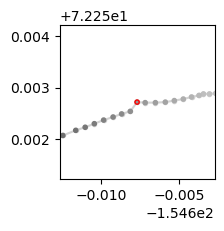

6777 2021-05-04 17:30:27 0.00537 centimeter / second ** 2


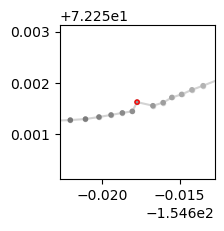

>>> removing 56 flagged values

v1  >>>  v2
0.72 % of the data is flagged
0.08 % of the data is flagged


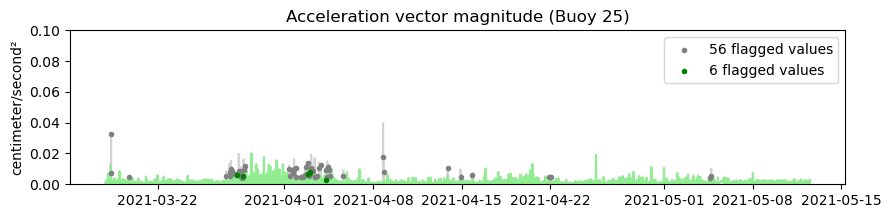

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1470 2021-03-28 05:10:26 0.00627 centimeter / second ** 2


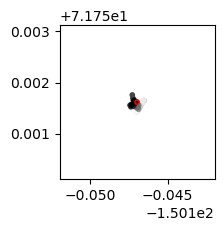

1524 2021-03-28 14:20:28 0.00519 centimeter / second ** 2


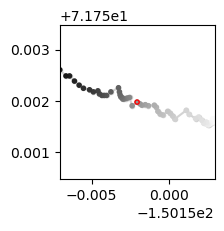

2253 2021-04-02 15:50:27 0.00677 centimeter / second ** 2


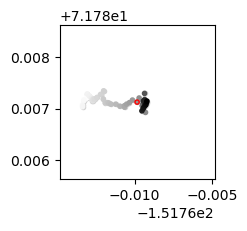

2266 2021-04-02 18:00:27 0.00708 centimeter / second ** 2


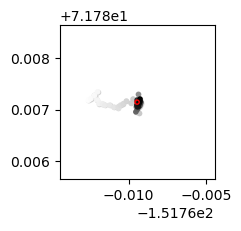

2275 2021-04-02 19:30:26 0.00811 centimeter / second ** 2


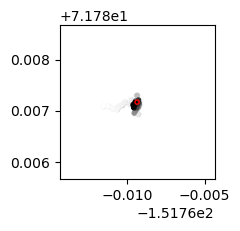

2440 2021-04-03 23:30:55 0.00300 centimeter / second ** 2


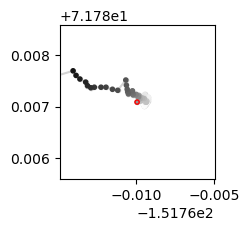

>>> removing 6 flagged values

v2  >>>  v3
0.72 % of the data is flagged
0.08 % of the data is flagged
0.00 % of the data is flagged


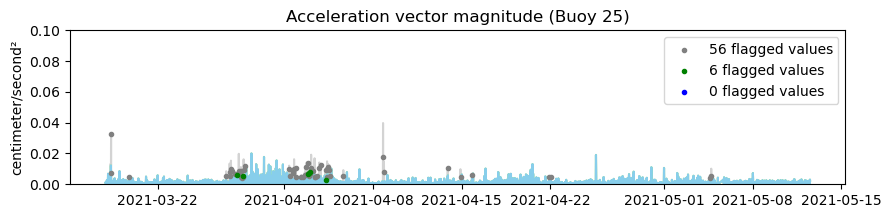

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
buoy 26


v0  >>>  v1
0.18 % of the data is flagged


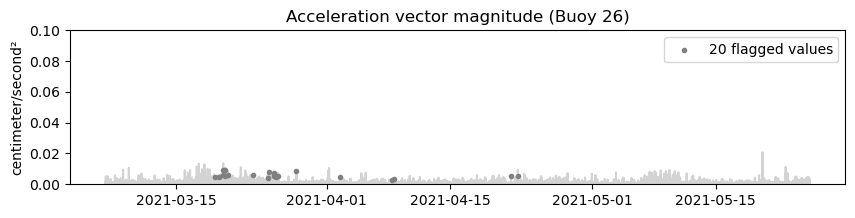

>>> removing 20 flagged values

v1  >>>  v2
0.18 % of the data is flagged
0.04 % of the data is flagged


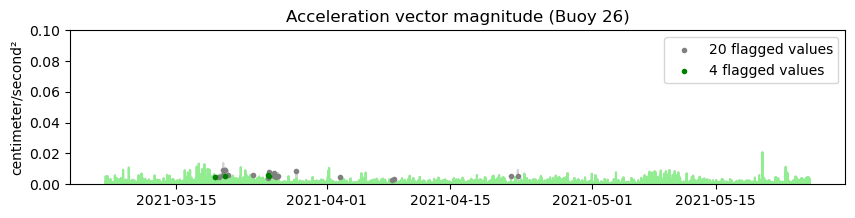

>>> removing 4 flagged values

v2  >>>  v3
0.18 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


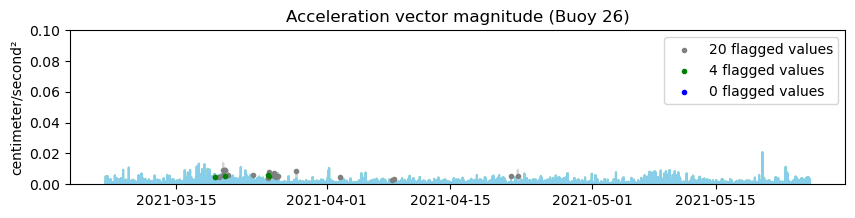

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_27_300534061091070.csv
buoy 27


v0  >>>  v1
0.45 % of the data is flagged


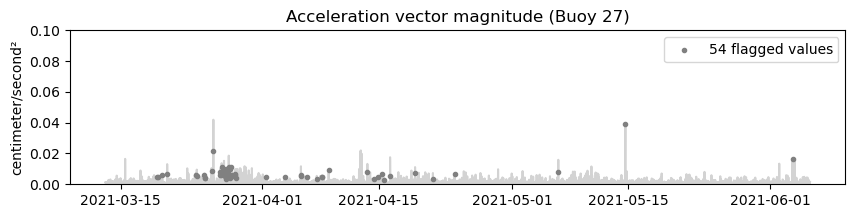

>>> removing 54 flagged values

v1  >>>  v2
0.45 % of the data is flagged
0.06 % of the data is flagged


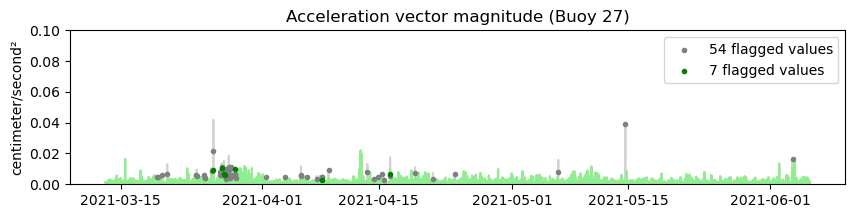

>>> removing 7 flagged values

v2  >>>  v3
0.45 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


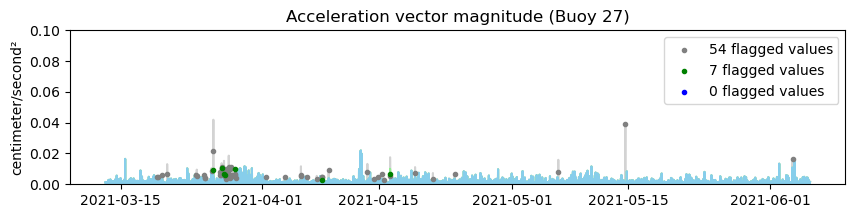

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
buoy 28


v0  >>>  v1
0.09 % of the data is flagged


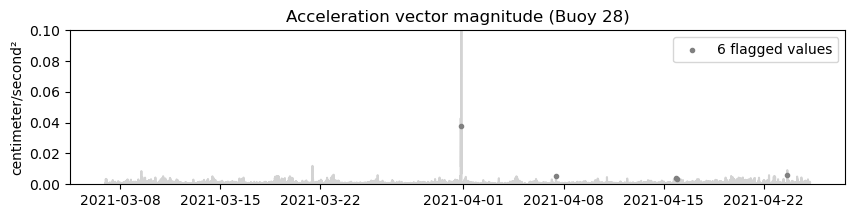

>>> removing 6 flagged values

v1  >>>  v2
0.09 % of the data is flagged
0.03 % of the data is flagged


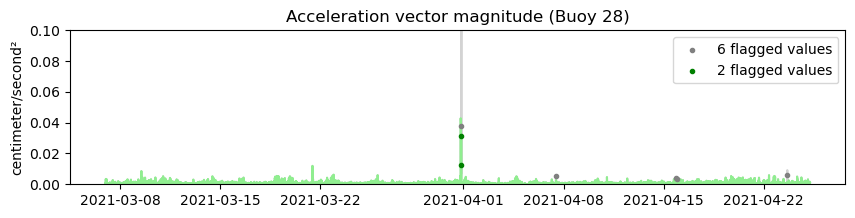

>>> removing 2 flagged values

v2  >>>  v3
0.09 % of the data is flagged
0.03 % of the data is flagged
0.01 % of the data is flagged


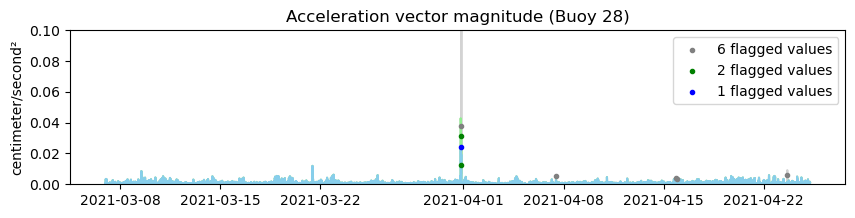

>>> removing 1 flagged values

v3  >>>  v4
0.09 % of the data is flagged
0.03 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


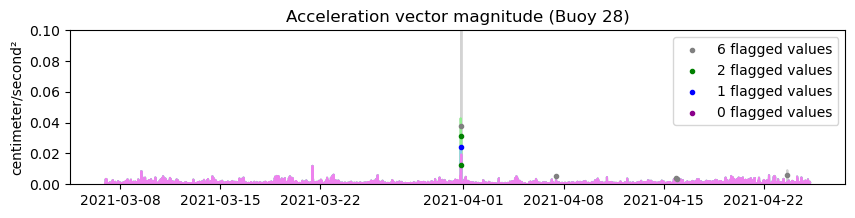

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_29_300534061093030.csv
buoy 29


v0  >>>  v1
0.24 % of the data is flagged


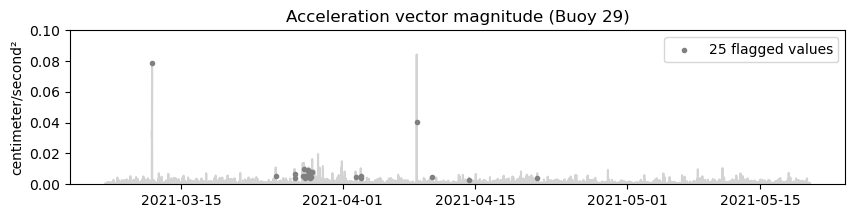

>>> removing 25 flagged values

v1  >>>  v2
0.24 % of the data is flagged
0.04 % of the data is flagged


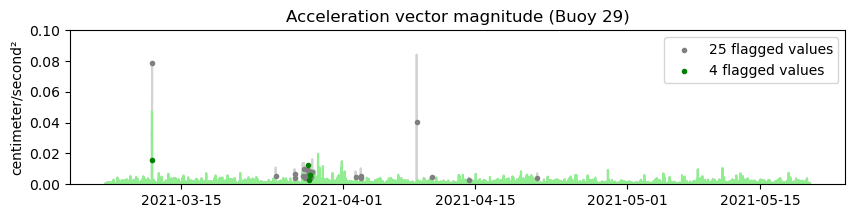

>>> removing 4 flagged values

v2  >>>  v3
0.24 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


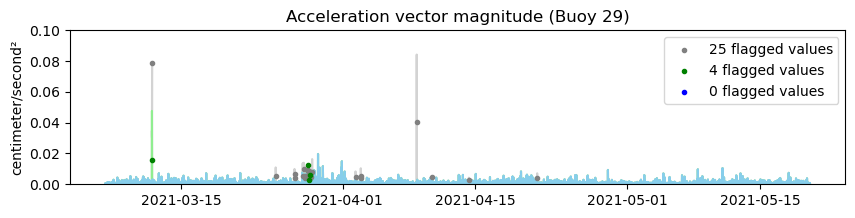

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_30_300534061093040.csv
buoy 30


v0  >>>  v1
1.54 % of the data is flagged


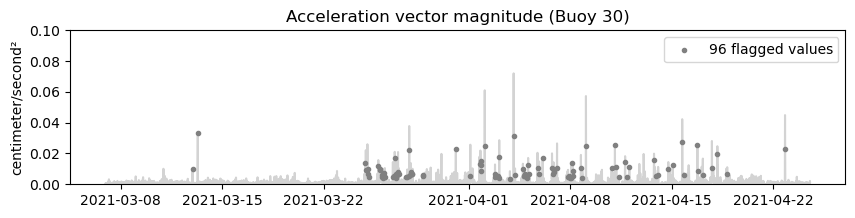

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

864 2021-03-12 23:20:25 0.00983 centimeter / second ** 2


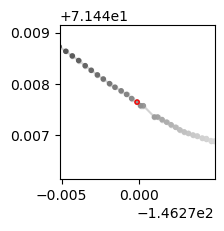

915 2021-03-13 07:53:59 0.03322 centimeter / second ** 2


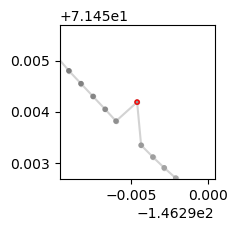

2571 2021-03-24 21:10:24 0.01370 centimeter / second ** 2


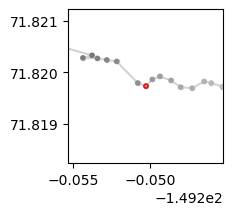

2577 2021-03-24 22:10:29 0.00926 centimeter / second ** 2


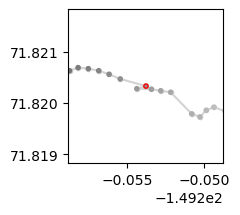

2593 2021-03-25 00:50:29 0.00964 centimeter / second ** 2


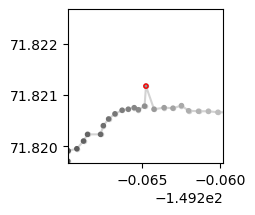

2602 2021-03-25 02:20:27 0.00689 centimeter / second ** 2


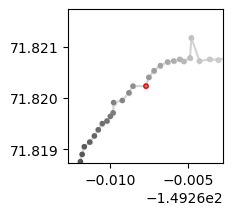

2606 2021-03-25 03:00:54 0.00477 centimeter / second ** 2


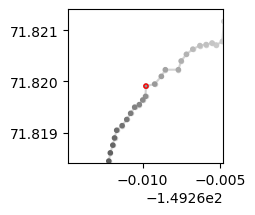

2701 2021-03-25 18:50:29 0.01213 centimeter / second ** 2


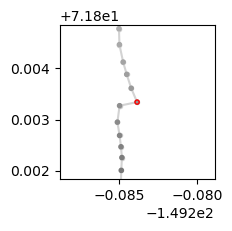

2716 2021-03-25 21:20:26 0.00995 centimeter / second ** 2


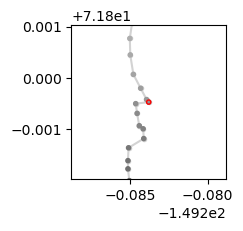

2721 2021-03-25 22:10:28 0.00936 centimeter / second ** 2


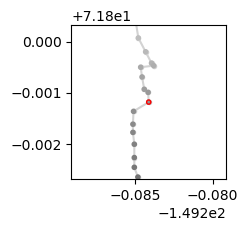

2733 2021-03-26 00:10:28 0.00623 centimeter / second ** 2


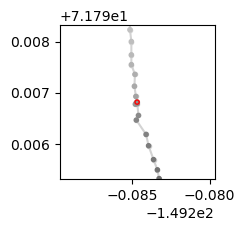

2736 2021-03-26 00:40:28 0.00485 centimeter / second ** 2


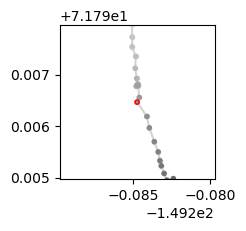

2744 2021-03-26 02:00:26 0.00438 centimeter / second ** 2


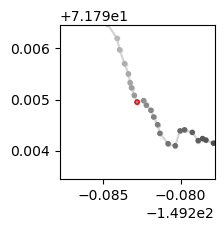

2752 2021-03-26 03:20:28 0.00764 centimeter / second ** 2


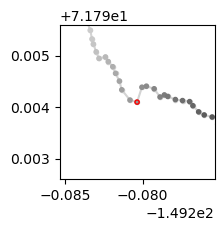

2767 2021-03-26 05:50:27 0.00485 centimeter / second ** 2


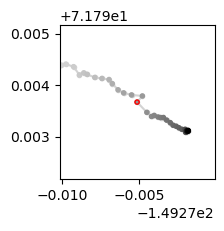

2845 2021-03-26 19:00:28 0.00461 centimeter / second ** 2


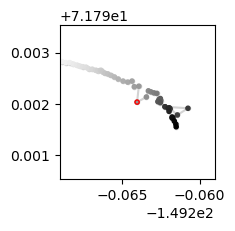

2850 2021-03-26 19:50:29 0.00519 centimeter / second ** 2


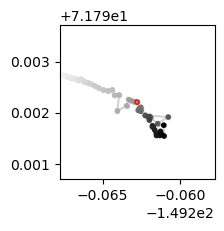

2863 2021-03-26 22:00:29 0.01689 centimeter / second ** 2


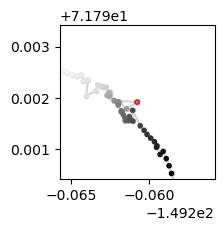

2875 2021-03-27 00:00:29 0.00436 centimeter / second ** 2


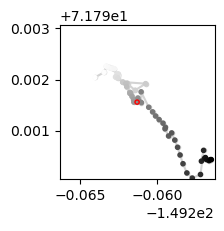

2879 2021-03-27 00:40:30 0.00692 centimeter / second ** 2


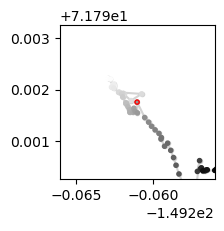

2887 2021-03-27 02:00:28 0.00621 centimeter / second ** 2


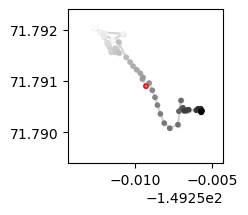

2896 2021-03-27 03:30:28 0.00815 centimeter / second ** 2


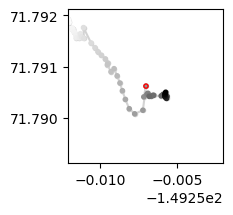

2905 2021-03-27 05:00:27 0.00635 centimeter / second ** 2


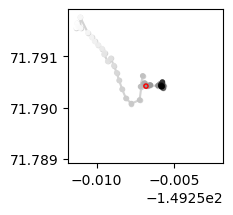

2958 2021-03-27 16:00:26 0.00500 centimeter / second ** 2


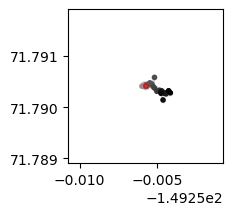

2973 2021-03-27 18:50:26 0.00445 centimeter / second ** 2


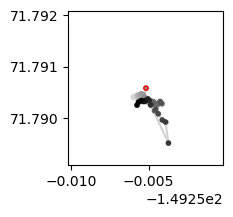

2987 2021-03-27 21:10:30 0.00559 centimeter / second ** 2


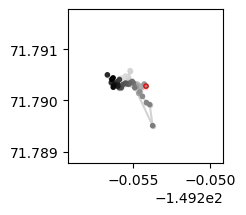

2992 2021-03-27 22:00:29 0.02254 centimeter / second ** 2


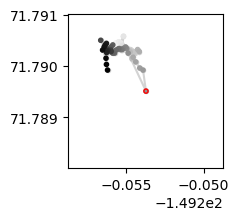

3003 2021-03-27 23:50:30 0.00633 centimeter / second ** 2


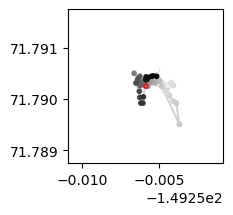

3008 2021-03-28 00:40:29 0.00796 centimeter / second ** 2


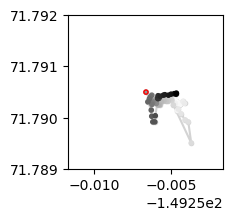

3014 2021-03-28 01:50:30 0.00662 centimeter / second ** 2


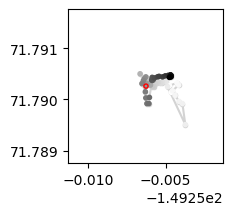

3022 2021-03-28 03:10:28 0.00668 centimeter / second ** 2


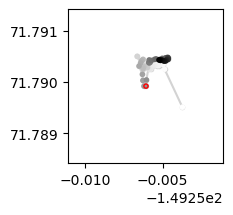

3122 2021-03-28 20:20:27 0.00564 centimeter / second ** 2


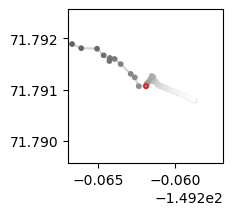

3128 2021-03-28 21:20:30 0.00628 centimeter / second ** 2


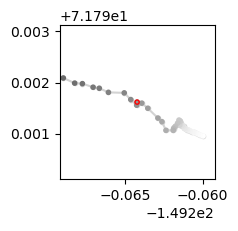

3427 2021-03-31 03:00:29 0.02297 centimeter / second ** 2


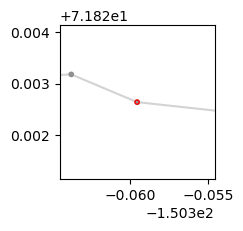

3557 2021-04-01 03:10:29 0.00557 centimeter / second ** 2


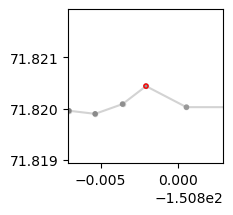

3632 2021-04-01 18:20:30 0.01317 centimeter / second ** 2


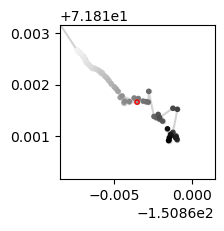

3641 2021-04-01 19:50:30 0.01489 centimeter / second ** 2


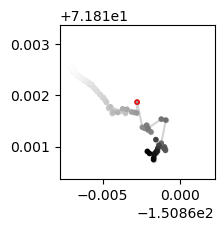

3647 2021-04-01 20:50:31 0.00839 centimeter / second ** 2


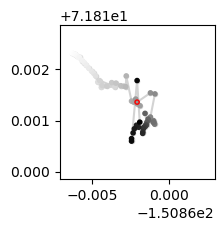

3649 2021-04-01 21:10:28 0.01256 centimeter / second ** 2


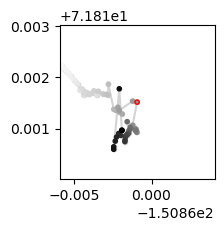

3675 2021-04-02 03:00:33 0.02508 centimeter / second ** 2


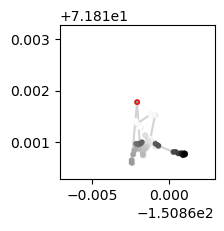

3747 2021-04-02 20:00:34 0.00640 centimeter / second ** 2


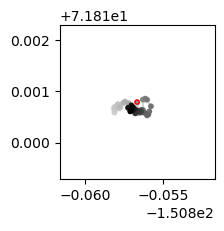

3749 2021-04-02 20:20:28 0.00478 centimeter / second ** 2


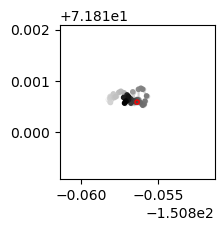

3773 2021-04-03 00:20:29 0.00516 centimeter / second ** 2


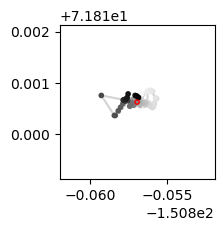

3781 2021-04-03 01:40:29 0.00435 centimeter / second ** 2


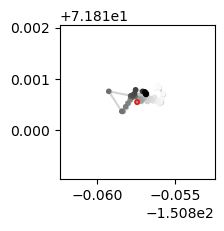

3789 2021-04-03 03:00:33 0.01743 centimeter / second ** 2


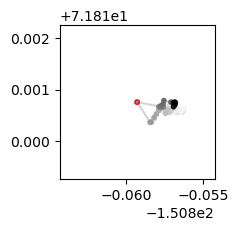

3863 2021-04-03 20:10:30 0.00371 centimeter / second ** 2


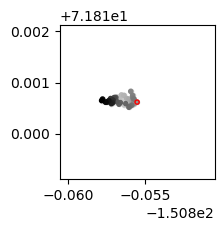

3897 2021-04-04 02:50:34 0.03143 centimeter / second ** 2


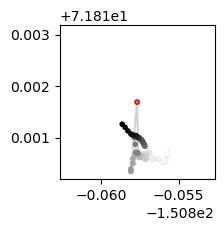

3903 2021-04-04 05:10:28 0.00598 centimeter / second ** 2


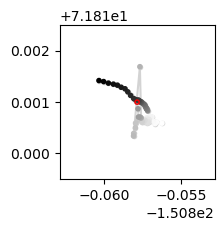

3964 2021-04-04 18:10:29 0.01000 centimeter / second ** 2


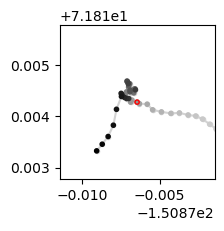

3974 2021-04-04 19:50:25 0.00505 centimeter / second ** 2


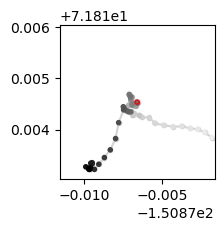

3977 2021-04-04 20:20:27 0.00507 centimeter / second ** 2


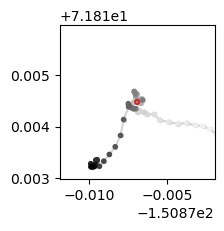

3982 2021-04-04 21:10:31 0.00599 centimeter / second ** 2


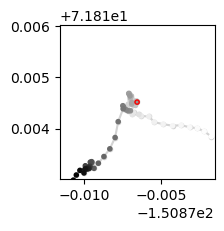

3987 2021-04-04 22:00:30 0.00677 centimeter / second ** 2


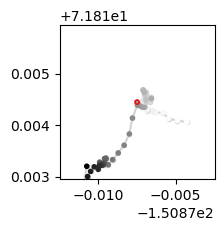

3994 2021-04-04 23:11:00 0.00533 centimeter / second ** 2


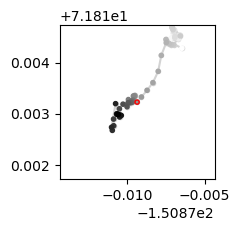

3998 2021-04-04 23:50:30 0.00535 centimeter / second ** 2


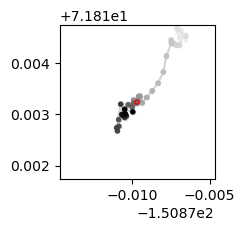

4008 2021-04-05 01:30:29 0.00434 centimeter / second ** 2


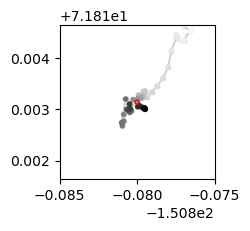

4014 2021-04-05 02:30:30 0.01280 centimeter / second ** 2


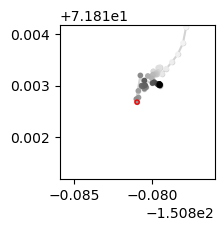

4025 2021-04-05 04:40:25 0.00678 centimeter / second ** 2


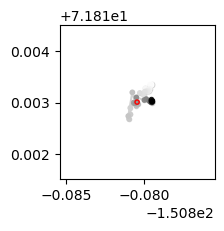

4084 2021-04-05 18:20:26 0.01058 centimeter / second ** 2


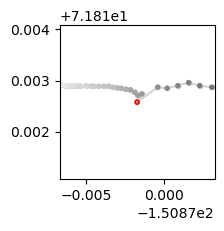

4100 2021-04-05 21:00:26 0.00643 centimeter / second ** 2


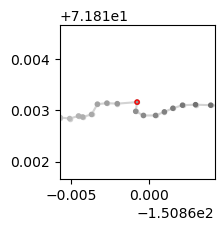

4134 2021-04-06 02:40:28 0.01675 centimeter / second ** 2


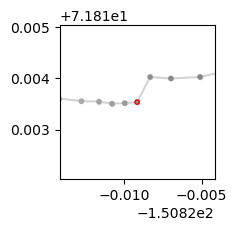

4209 2021-04-06 18:20:30 0.01062 centimeter / second ** 2


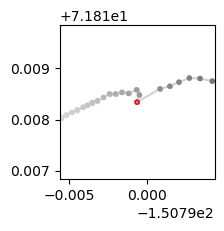

4222 2021-04-06 20:30:28 0.00658 centimeter / second ** 2


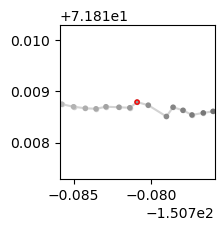

4224 2021-04-06 20:50:29 0.00773 centimeter / second ** 2


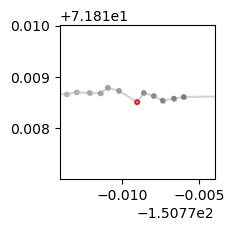

4251 2021-04-07 02:40:32 0.01028 centimeter / second ** 2


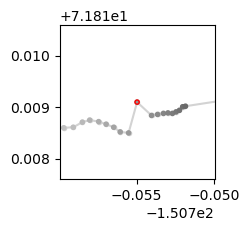

4332 2021-04-07 20:10:27 0.00473 centimeter / second ** 2


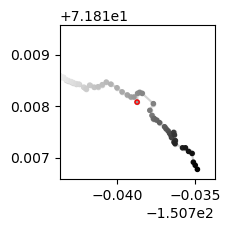

4349 2021-04-07 23:01:02 0.00517 centimeter / second ** 2


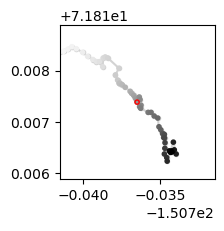

4353 2021-04-07 23:40:30 0.00427 centimeter / second ** 2


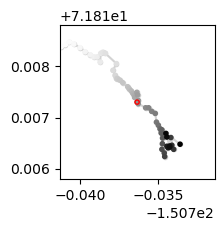

4362 2021-04-08 01:10:31 0.00437 centimeter / second ** 2


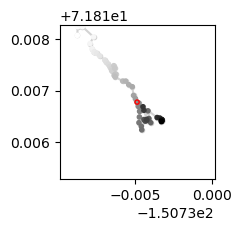

4370 2021-04-08 02:30:27 0.01369 centimeter / second ** 2


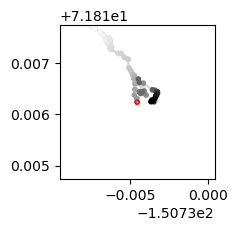

4378 2021-04-08 04:20:26 0.00528 centimeter / second ** 2


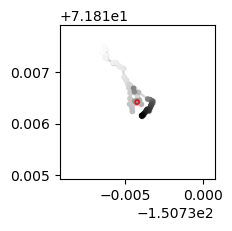

4381 2021-04-08 04:50:28 0.00858 centimeter / second ** 2


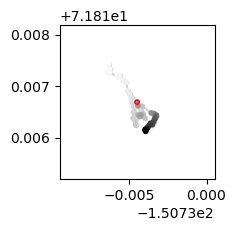

4443 2021-04-08 18:10:30 0.01058 centimeter / second ** 2


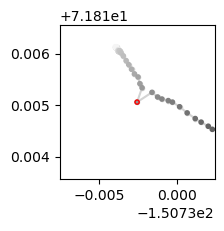

4457 2021-04-08 20:30:28 0.00434 centimeter / second ** 2


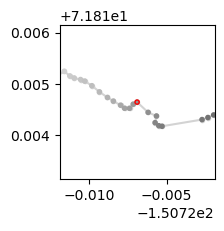

4487 2021-04-09 02:30:34 0.02460 centimeter / second ** 2


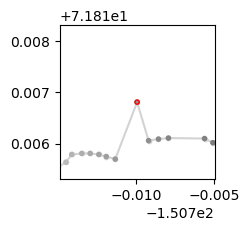

4680 2021-04-10 20:50:29 0.01027 centimeter / second ** 2


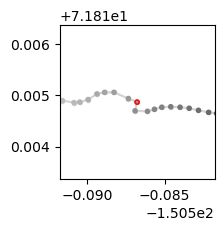

4713 2021-04-11 02:20:29 0.02542 centimeter / second ** 2


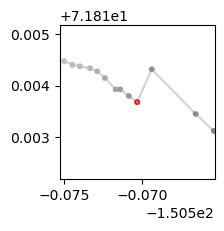

4720 2021-04-11 04:30:27 0.01125 centimeter / second ** 2


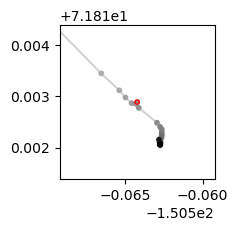

4743 2021-04-11 08:50:26 0.00448 centimeter / second ** 2


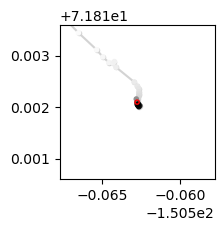

4783 2021-04-11 19:20:29 0.01462 centimeter / second ** 2


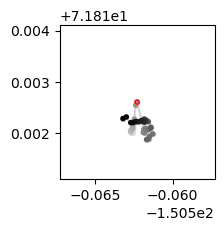

4794 2021-04-11 22:30:29 0.00480 centimeter / second ** 2


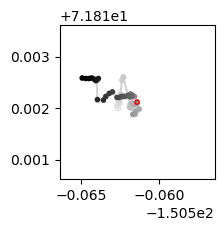

4815 2021-04-12 02:10:28 0.01097 centimeter / second ** 2


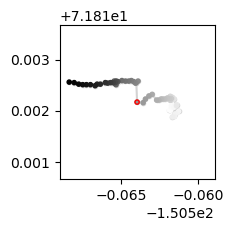

5019 2021-04-13 19:10:28 0.01581 centimeter / second ** 2


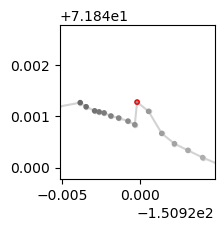

5036 2021-04-13 22:50:32 0.00534 centimeter / second ** 2


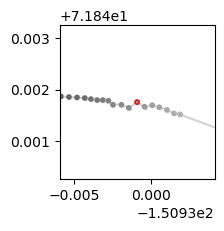

5056 2021-04-14 02:10:34 0.00597 centimeter / second ** 2


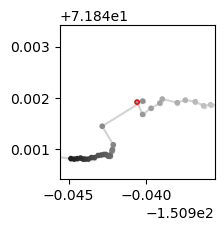

5114 2021-04-14 18:50:29 0.00984 centimeter / second ** 2


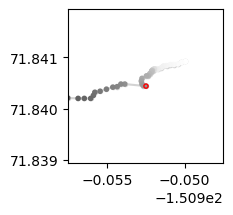

5150 2021-04-15 02:00:28 0.01235 centimeter / second ** 2


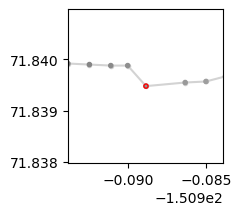

5225 2021-04-15 17:50:31 0.02731 centimeter / second ** 2


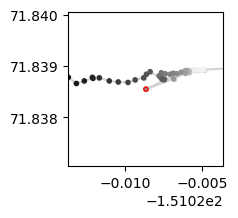

5246 2021-04-15 21:20:30 0.00588 centimeter / second ** 2


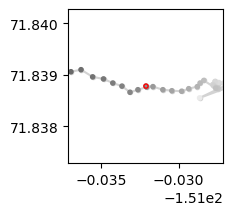

5352 2021-04-16 18:50:27 0.02562 centimeter / second ** 2


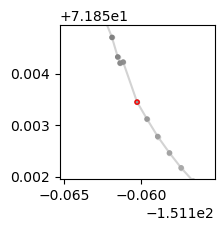

5354 2021-04-16 19:10:30 0.00836 centimeter / second ** 2


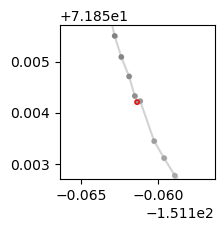

5397 2021-04-17 04:00:34 0.00570 centimeter / second ** 2


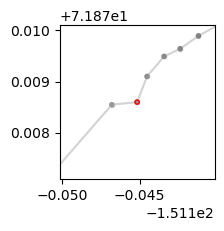

5464 2021-04-17 19:00:28 0.01051 centimeter / second ** 2


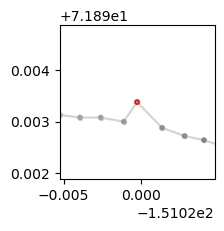

5516 2021-04-18 04:00:30 0.01981 centimeter / second ** 2


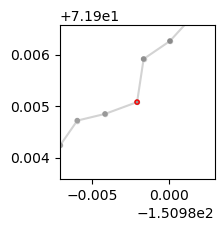

5590 2021-04-18 20:20:29 0.00646 centimeter / second ** 2


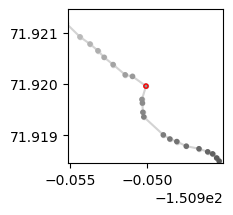

6040 2021-04-22 20:00:30 0.02316 centimeter / second ** 2


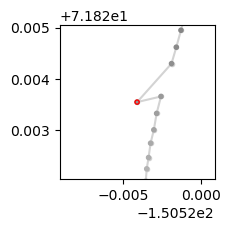

>>> removing 96 flagged values

v1  >>>  v2
1.54 % of the data is flagged
0.20 % of the data is flagged


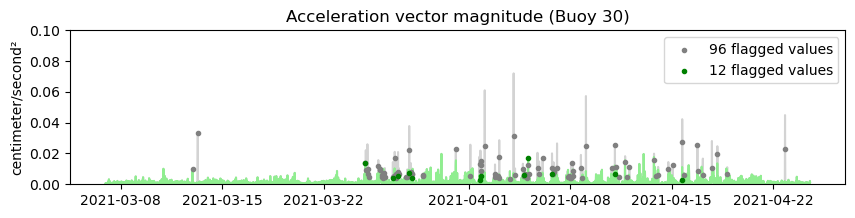

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

2569 2021-03-24 20:50:26 0.01390 centimeter / second ** 2


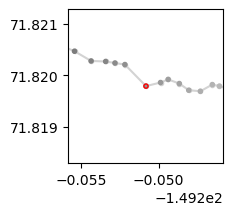

2830 2021-03-26 16:30:26 0.00435 centimeter / second ** 2


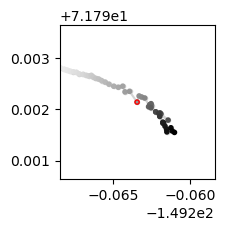

2873 2021-03-26 23:40:28 0.00513 centimeter / second ** 2


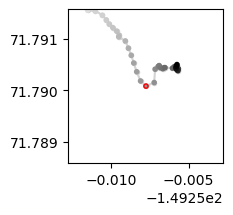

2960 2021-03-27 16:20:25 0.00727 centimeter / second ** 2


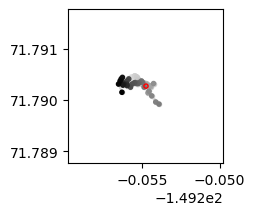

2991 2021-03-27 21:50:28 0.00422 centimeter / second ** 2


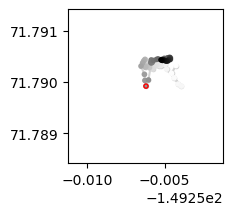

3597 2021-04-01 09:50:25 0.00299 centimeter / second ** 2


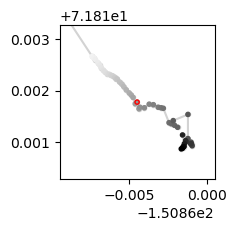

3609 2021-04-01 14:30:32 0.00510 centimeter / second ** 2


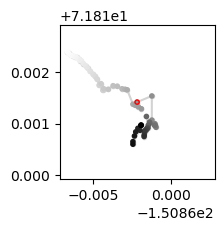

3927 2021-04-04 09:20:27 0.00626 centimeter / second ** 2


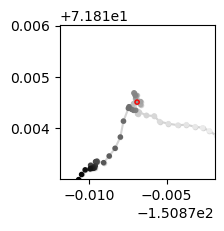

3958 2021-04-04 17:10:25 0.01708 centimeter / second ** 2


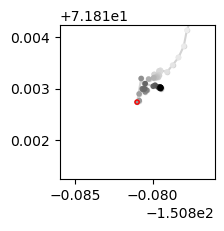

4146 2021-04-06 05:10:25 0.00685 centimeter / second ** 2


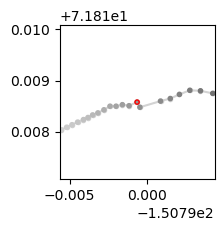

4636 2021-04-10 10:30:26 0.00677 centimeter / second ** 2


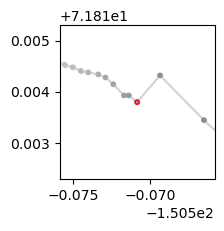

5137 2021-04-14 23:40:31 0.00285 centimeter / second ** 2


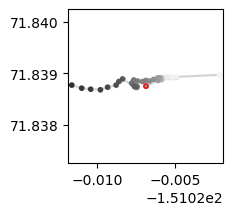

>>> removing 12 flagged values

v2  >>>  v3
1.54 % of the data is flagged
0.20 % of the data is flagged
0.03 % of the data is flagged


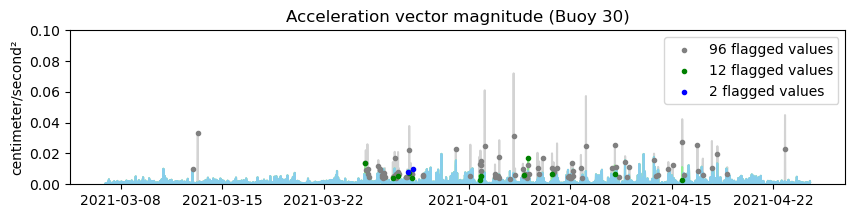

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

2955 2021-03-27 15:30:26 0.00778 centimeter / second ** 2


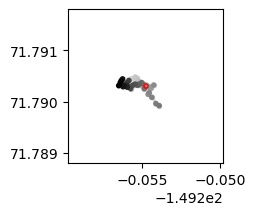

2987 2021-03-27 21:10:30 0.01005 centimeter / second ** 2


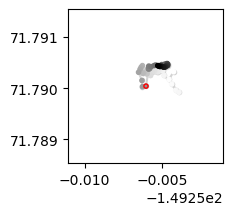

>>> removing 2 flagged values

v3  >>>  v4
1.54 % of the data is flagged
0.20 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


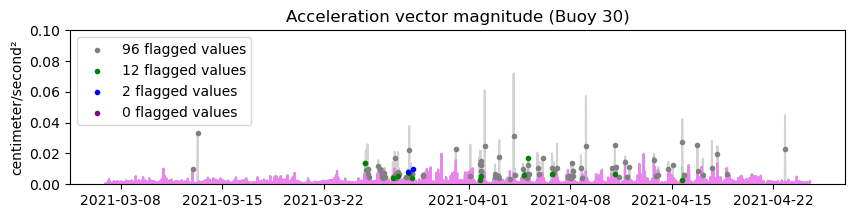

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_31_300534061093070.csv
buoy 31


v0  >>>  v1
0.22 % of the data is flagged


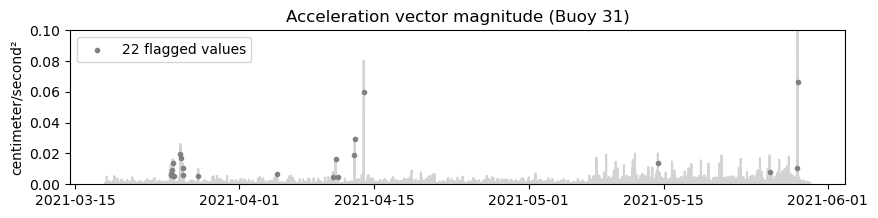

>>> removing 22 flagged values

v1  >>>  v2
0.22 % of the data is flagged
0.03 % of the data is flagged


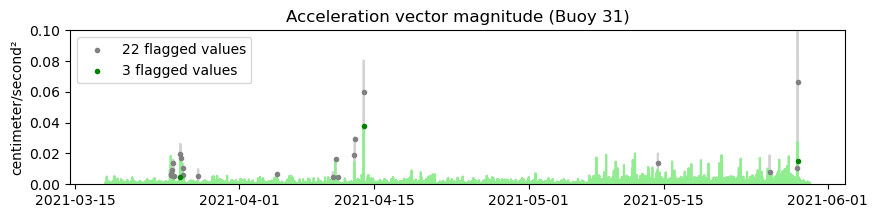

>>> removing 3 flagged values

v2  >>>  v3
0.22 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


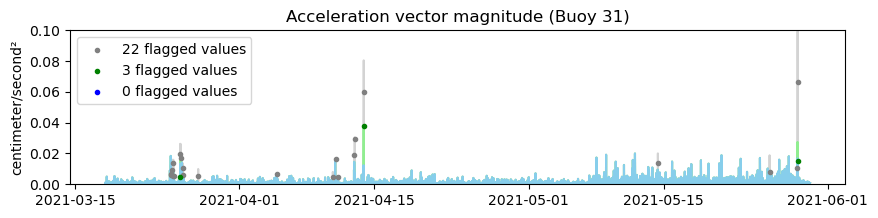

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_32_300534061094090.csv
buoy 32


v0  >>>  v1
0.11 % of the data is flagged


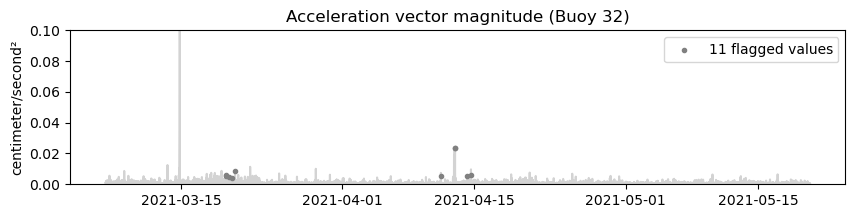

>>> removing 11 flagged values

v1  >>>  v2
0.11 % of the data is flagged
0.02 % of the data is flagged


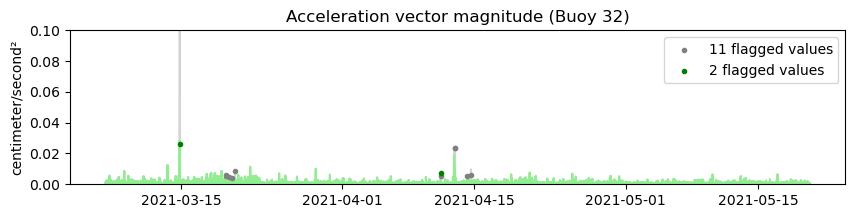

>>> removing 2 flagged values

v2  >>>  v3
0.11 % of the data is flagged
0.02 % of the data is flagged
0.00 % of the data is flagged


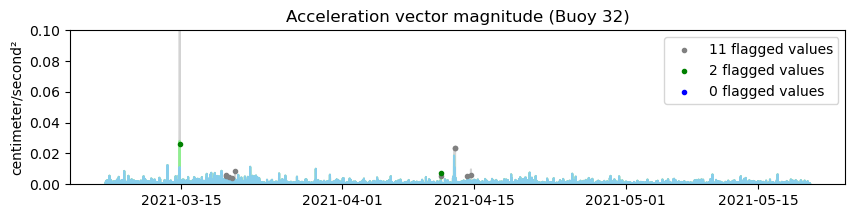

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_33_300534061095060.csv
buoy 33


v0  >>>  v1
0.13 % of the data is flagged


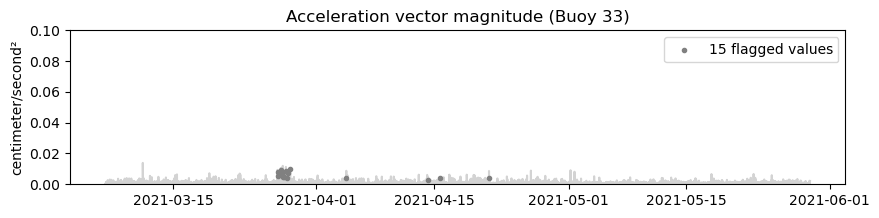

>>> removing 15 flagged values

v1  >>>  v2
0.13 % of the data is flagged
0.01 % of the data is flagged


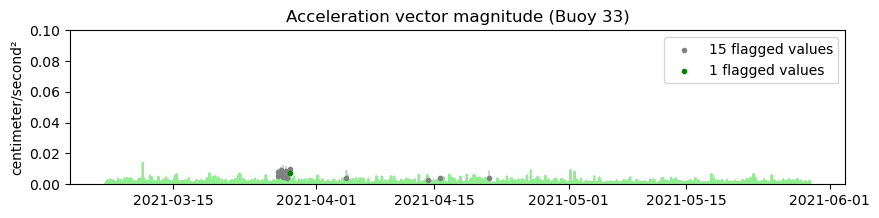

>>> removing 1 flagged values

v2  >>>  v3
0.13 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


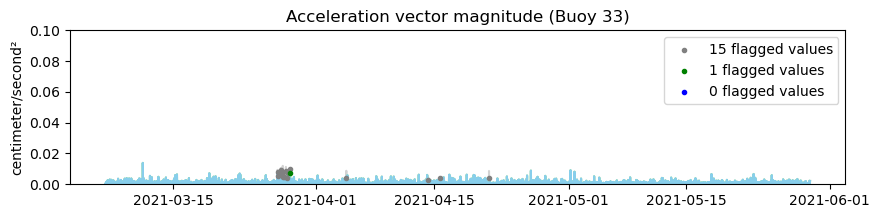

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_1_300534061095090.csv
buoy 34_1


v0  >>>  v1
0.10 % of the data is flagged


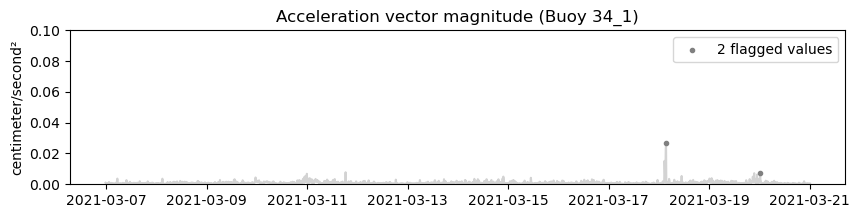

>>> removing 2 flagged values

v1  >>>  v2
0.10 % of the data is flagged
0.00 % of the data is flagged


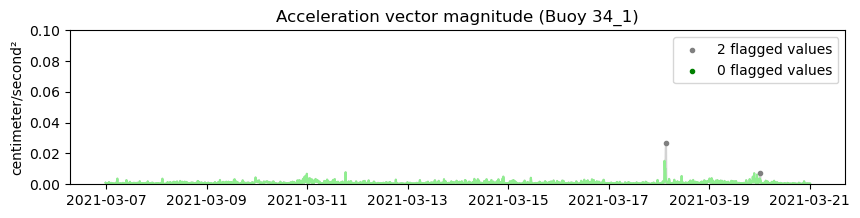

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_2_300534061095090.csv
buoy 34_2


v0  >>>  v1
0.04 % of the data is flagged


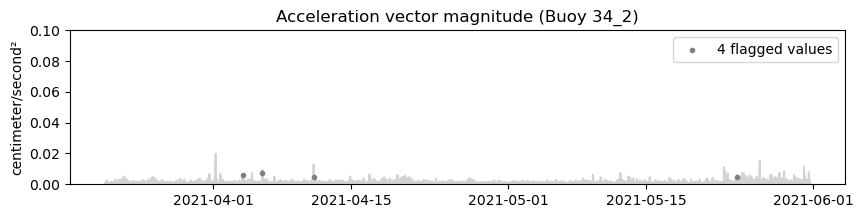

>>> removing 4 flagged values

v1  >>>  v2
0.04 % of the data is flagged
0.00 % of the data is flagged


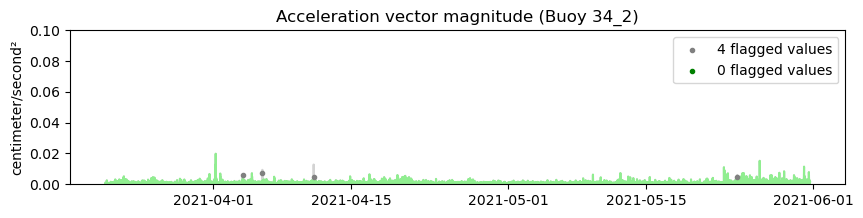

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_35_300534061096000.csv
buoy 35


v0  >>>  v1
1.13 % of the data is flagged


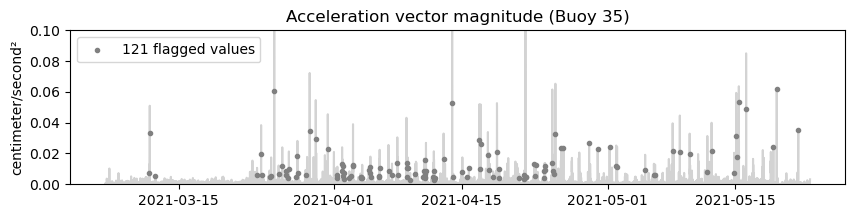

>>> removing 121 flagged values

v1  >>>  v2
1.13 % of the data is flagged
0.10 % of the data is flagged


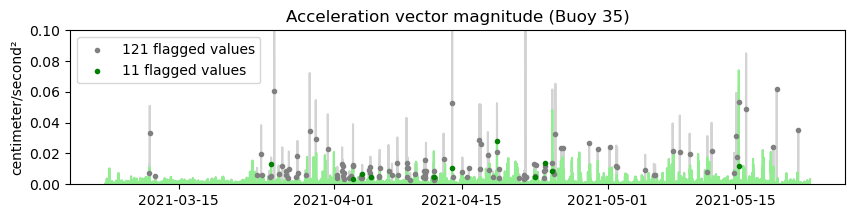

>>> removing 11 flagged values

v2  >>>  v3
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged


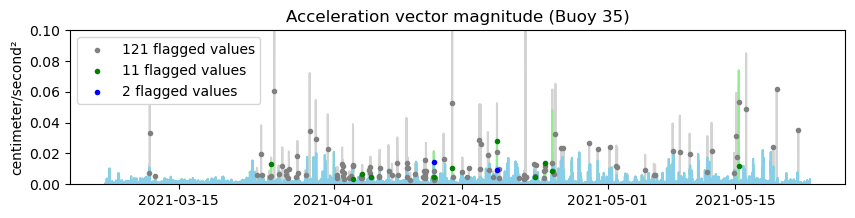

>>> removing 2 flagged values

v3  >>>  v4
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged


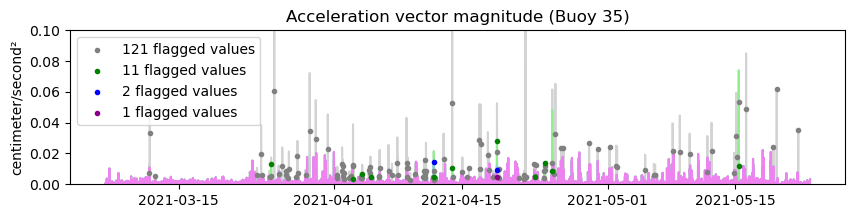

>>> removing 1 flagged values

v4  >>>  v5
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


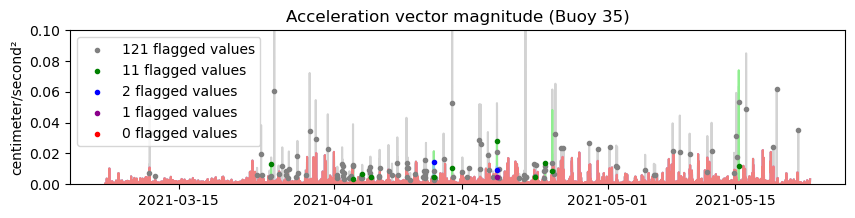

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_36_300534061096010.csv
buoy 36


v0  >>>  v1
0.36 % of the data is flagged


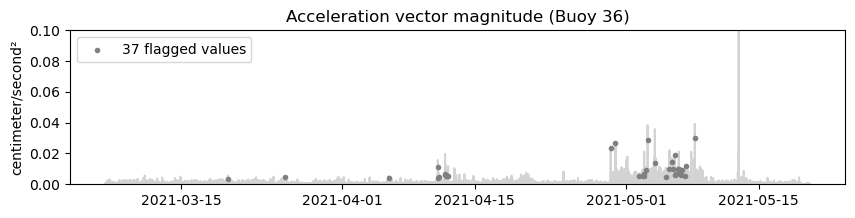

>>> removing 37 flagged values

v1  >>>  v2
0.36 % of the data is flagged
0.06 % of the data is flagged


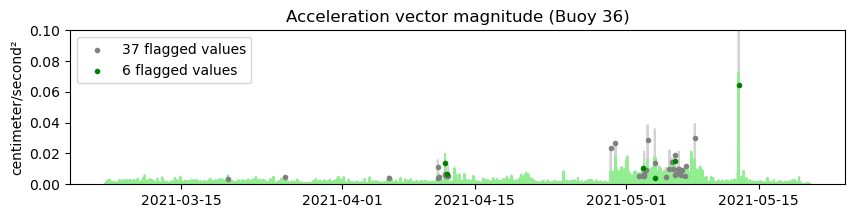

>>> removing 6 flagged values

v2  >>>  v3
0.36 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


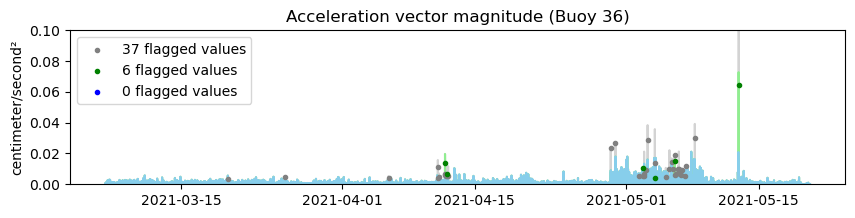

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_37_300534061096020.csv
buoy 37


v0  >>>  v1
0.12 % of the data is flagged


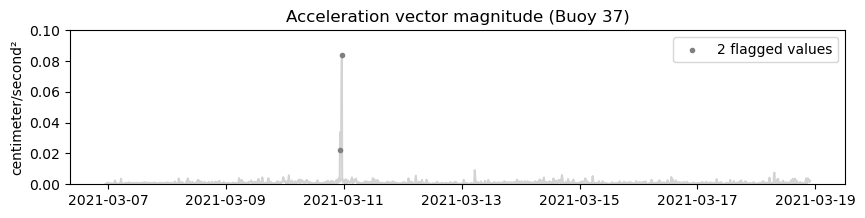

>>> removing 2 flagged values

v1  >>>  v2
0.12 % of the data is flagged
0.06 % of the data is flagged


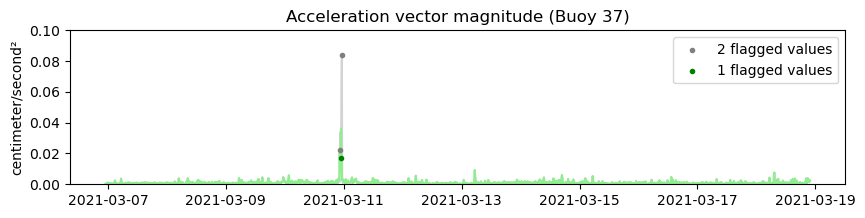

>>> removing 1 flagged values

v2  >>>  v3
0.12 % of the data is flagged
0.06 % of the data is flagged
0.06 % of the data is flagged


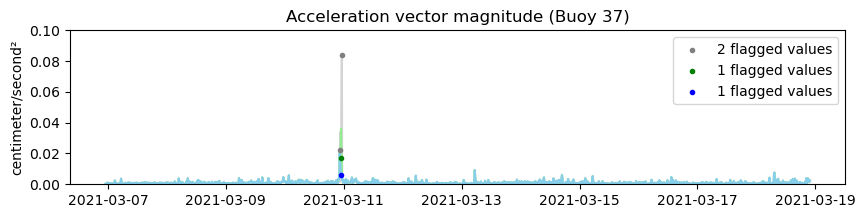

>>> removing 1 flagged values

v3  >>>  v4
0.12 % of the data is flagged
0.06 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


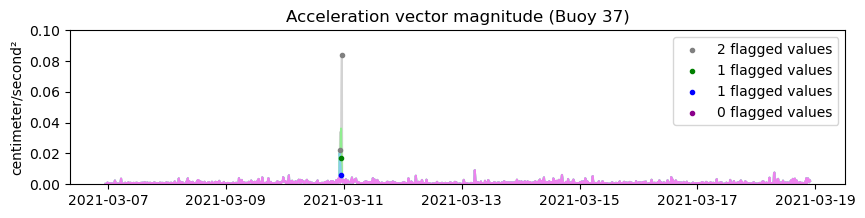

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_38_300534061096060.csv
buoy 38


v0  >>>  v1
0.23 % of the data is flagged


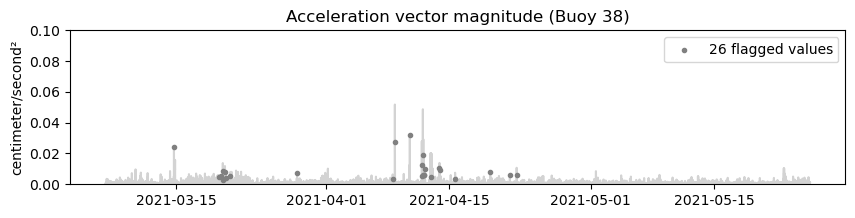

>>> removing 26 flagged values

v1  >>>  v2
0.23 % of the data is flagged
0.04 % of the data is flagged


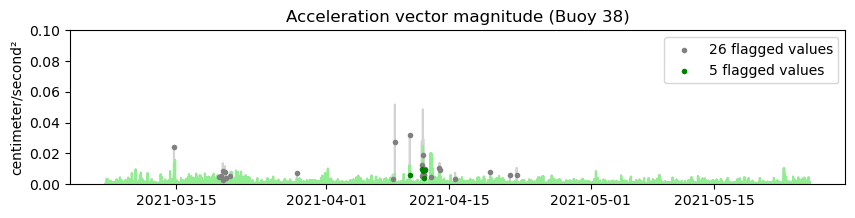

>>> removing 5 flagged values

v2  >>>  v3
0.23 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


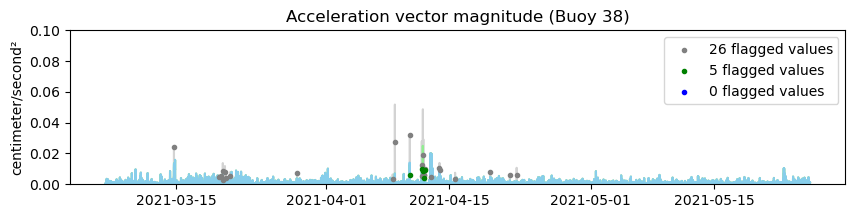

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_39_300534061097010.csv
buoy 39


v0  >>>  v1
0.46 % of the data is flagged


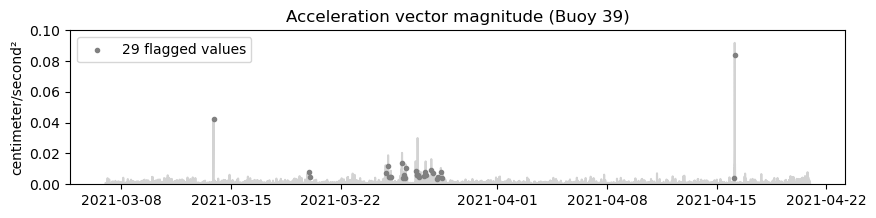

>>> removing 29 flagged values

v1  >>>  v2
0.46 % of the data is flagged
0.10 % of the data is flagged


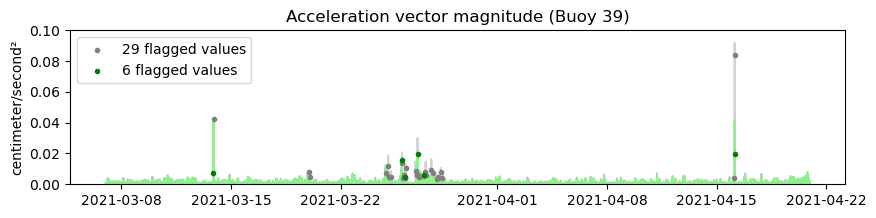

>>> removing 6 flagged values

v2  >>>  v3
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged


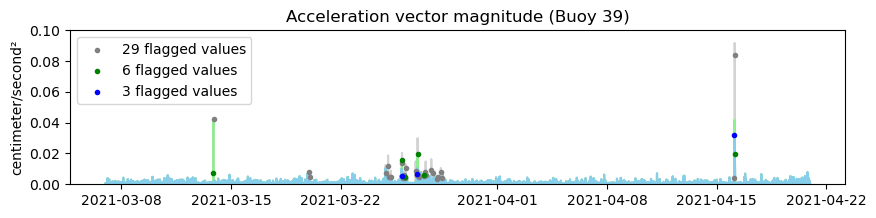

>>> removing 3 flagged values

v3  >>>  v4
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged
0.03 % of the data is flagged


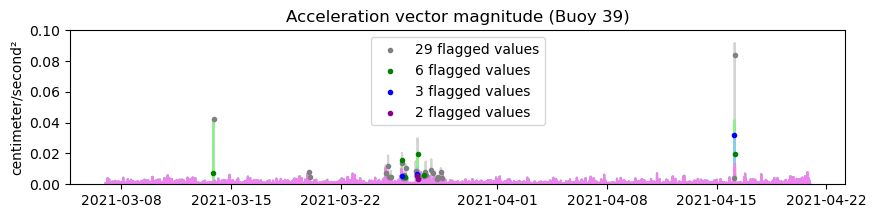

>>> removing 2 flagged values

v4  >>>  v5
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


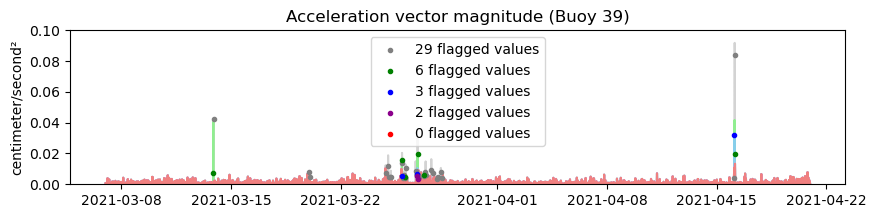

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_40_300534061097050.csv
buoy 40


v0  >>>  v1
0.27 % of the data is flagged


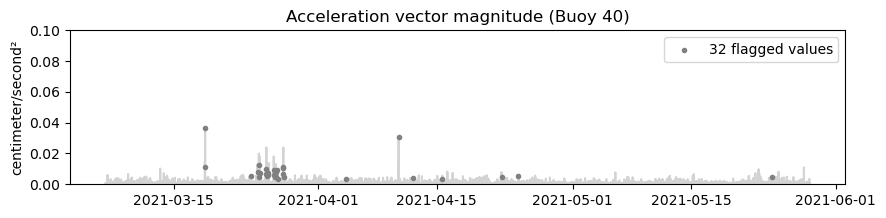

>>> removing 32 flagged values

v1  >>>  v2
0.27 % of the data is flagged
0.07 % of the data is flagged


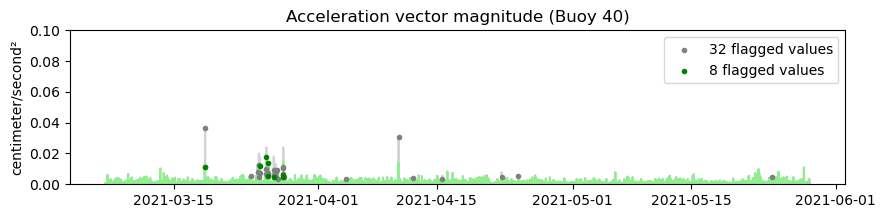

>>> removing 8 flagged values

v2  >>>  v3
0.27 % of the data is flagged
0.07 % of the data is flagged
0.03 % of the data is flagged


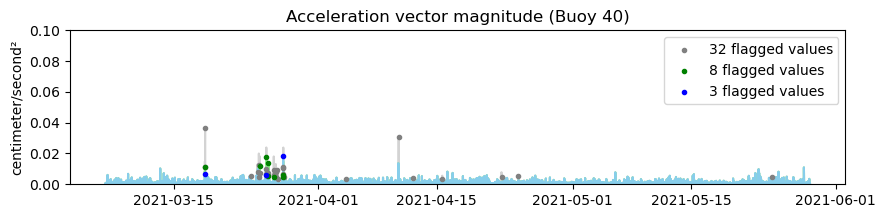

>>> removing 3 flagged values

v3  >>>  v4


In [ ]:
clean = {}

for file in csv_files:
    
    print(file)

    # grab buoy num
    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    print(f'buoy {buoy_num}\n')
    
    df = pd.read_csv(file)
    raw_dates = pd.to_datetime(df.datetime.values)
    raw_lat = df.latitude.values
    raw_lon = df.longitude.values

    clean[buoy_num] = {}
    clean[buoy_num]['lat'] = {}
    clean[buoy_num]['lon'] = {}
    clean[buoy_num]['time'] = {}
    clean[buoy_num]['acc'] = {}
    clean[buoy_num]['flag'] = {}

    clean[buoy_num]['lat']['v0'] = raw_lat
    clean[buoy_num]['lon']['v0'] = raw_lon
    clean[buoy_num]['time']['v0'] = raw_dates

    if buoy_num in ['23', '25', '30']:
        show_tracks = True
    else:
        show_tracks = False

    iterations = 0
    num_flags = 100

    while (iterations < 6) and (num_flags > 0):

        # specify current and next versions
        #==================================
        vi = f'v{iterations}'
        vn = f'v{iterations+1}'
        #==================================
        print(f'\n{vi}  >>>  {vn}')

        # run cleaning
        clean[buoy_num] = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = clean[buoy_num], 
                                           show_velocity = False, show_acceleration = True, show_tracks = show_tracks)

        # find flags from vi used to create vf
        latest_flags = clean[buoy_num]['flag'][vi]
        num_flags = len(latest_flags)

        iterations+=1

In [435]:
# print('Acceleration percentile values')
# for perc in [99.0, 99.5, 99.9]:
#     print(f'  - {perc}% : {np.nanpercentile(all_acc, perc):.6f} cm/s2 ({3600*np.nanpercentile(all_acc, perc):.2f} (cm/s)/hr)')
# print(f"\nSo let's use acceleration 0.01 cm/s2 threshold")

Acceleration percentile values
  - 99.0% : 0.006302 cm/s2 (22.69 (cm/s)/hr)
  - 99.5% : 0.009108 cm/s2 (32.79 (cm/s)/hr)
  - 99.9% : 0.022001 cm/s2 (79.20 (cm/s)/hr)

So let's use acceleration 0.01 cm/s2 threshold


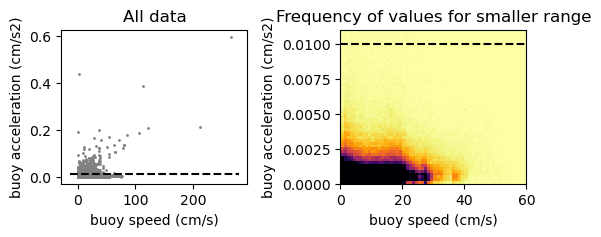

In [436]:
# fig, axs = plt.subplots(1,2,figsize=(6,2))
# plt.subplots_adjust(wspace=0.5)
# axs[0].set_title('All data')
# axs[0].set_xlabel('buoy speed (cm/s)')
# axs[0].set_ylabel('buoy acceleration (cm/s2)')
# axs[0].scatter(all_spe, all_acc, s = 1, c='gray');
# axs[0].hlines(0.01, *axs[0].get_xlim(), colors='k', linestyles='dashed', label='99.9%')

# spe_nonan = all_spe[np.isnan(all_acc) == False]
# acc_nonan = all_acc[np.isnan(all_acc) == False]
# axs[1].set_title('Frequency of values for smaller range')
# axs[1].set_xlabel('buoy speed (cm/s)')
# axs[1].set_ylabel('buoy acceleration (cm/s2)')
# axs[1].hist2d(spe_nonan, acc_nonan, bins=[np.arange(0,61,1), np.arange(0,0.015, 0.0002)], 
#               cmap='inferno_r', vmin=0, vmax = 500);
# axs[1].set_ylim(0,0.011)
# axs[1].set_xlim(0,60)
# axs[1].hlines(0.01, *axs[1].get_xlim(), colors='k', linestyles='dashed', label='99.9%')

In [ ]:
# def identify_rebounds(acc_u = [], acc_v = [], thresh = 0.001 * units('cm/s')/units('s'), show_plot=False):
    
#     flag_indices = np.array([], dtype=int)
    
    
#     for aa, acc in enumerate([acc_u, acc_v]):
    
#         # normalize accelerations to -1, 0, or 1 relative to threshold
#         # (acc > +thresh) = 1
#         # (acc < -thresh) = -1
#         # (-thresh < acc < +thresh) = 0
#         norm_acc = np.copy(acc.magnitude)
#         norm_acc[np.abs(acc) >= thresh] = 1 * np.sign(acc)[np.abs(acc) >= thresh]
#         norm_acc[np.abs(acc) < thresh] = 0

#         if aa == 0:
#             norm_acc_u = np.copy(norm_acc)
#         else:
#             norm_acc_v = np.copy(norm_acc)
            
#         # normalized accelerations sequences you'd see 
#         # centered around rebound-type tracks
#         seq1 = np.array([-1,1,-1])
#         seq2 = np.array([1,-1,1])

#         # identify where any of these sequences exist
#         for ii in range(1, len(norm_acc)-1):
#             diff1_array = np.abs(norm_acc[ii-1:ii+1+1] - seq1)
#             diff2_array = np.abs(norm_acc[ii-1:ii+1+1] - seq2)
#             if (np.sum(diff1_array) == 0) or (np.sum(diff2_array) == 0):
#                 print(ii, norm_acc[ii-1:ii+1+1])
#                 flag_indices = np.append(flag_indices, ii)

#     # remove any duplicates
#     flag_indices = np.unique(flag_indices)
            
#     if show_plot:
#         fig, axs = plt.subplots(2,1,figsize=(8,3))
        
#         axs[0].plot(norm_acc_u, c='k', label='normalized')
#         axs[0].set_ylim(-1.5,1.5)
#         ax2 = axs[0].twinx()
#         ax2.set_ylim(-5*thresh.magnitude,5*thresh.magnitude)
#         ax2.plot(acc_u, c='lightblue', label='acc_u')
#         ax2.legend()
        
#         axs[1].plot(norm_acc_v, c='k', label='normalized')
#         axs[1].set_ylim(-1.5,1.5)
#         ax3 = axs[1].twinx()
#         ax3.set_ylim(-5*thresh.magnitude,5*thresh.magnitude)
#         ax3.plot(acc_v, c='lightcoral', label='acc_v')
#         ax3.legend()
        
#         for II in flag_indices:
#             axs[0].vlines(II, *axs[0].get_ylim(), colors='b')
#             axs[1].vlines(II, *axs[1].get_ylim(), colors='r')
            
#             print(acc_u[II-1:II+2])
#             print(acc_v[II-1:II+2])
#             print()
#     return flag_indices